# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Описание данных

* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах(м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении
Пояснение: апартаменты — это нежилые помещения, не относящиеся к жилому фонду, но имеющие необходимые условия для проживания.

### Содержание<a id="content"></a>

1. [Загрузка данных](#load_data)
2. [Предобработка данных](#data_preprocessing)
    * [Переименование столбцов](#column_renaming)
    * [Обработка пропущенных значений](#missing_values)
    * [Замена типов](#data_typization)
    * [Обработка аномалий](#anomalies)
    * [Обработка дубликатов](#duplicates)
3. [Добавление столбцов](#add_to_table)
4. [Исследовательский анализ данных](#explanatory_data_analysis)
5. [Заключение](#conclusion)

<a id="load_data"></a>
### Шаг 1. Откройте файл с данными и изучите общую информацию. 

Импортируем необходимые библиотеки, загрузим данные и посмотрим на первые записи. При чтении csv-файла будем использовать автоматическое определение разделителя с помощью движка python.

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from functools import partialmethod


real_estate_df = pd.read_csv('real_estate_data.csv', sep=None, engine='python')
real_estate_df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Заметим, что формат даты и времени соответствует стандарту ISO 8601. В дальнейшем <span style="color:red">необходимо</span> будет привести формат даты к более удобному для восприятия. (Здесь и далее в разделе изучения информации исходных данных будем выделять красным цветом слово "необходимо", чтобы не забыть выполнить данное действие в разделе предобработки данных.)  
Теперь взглянем на общую информацию о датафрейме.

In [2]:
real_estate_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Данные представлены таблицей с 22 столбцами и 23699 записями.  
После первого взгляда на общую информацию можем выделить следующие заметки:
* часть данных пропущена, причём в столбцах 'is_apartment', 'ponds_around3000' и 'ponds_nearest' пропуски составляют большую часть;
* название столбца 'cityCenters_nearest' выбивается из общего стиля (<span style="color:red">необходимо</span> будет привести к lower_case_with_underscores);
* названия столбцов 'studio' и 'open_plan' логически не подходят под тип данных 'bool' (<span style="color:red">необходимо</span> будет добавить префикс 'is_');
* все количественные признаки имеют формат 'float64', что не везде оправдано, а также столбец 'is_apartment' строкового типа, хотя по смыслу и содержанию это булевый признак, поэтому <span style="color:red">необходимо</span> будет провести типизацию данных в соответствии с содержимым.

Пробежимся по столбцам в поисках возможных аномалий и дубликатов.

total_images
count    23699.000000
mean         9.858475
std          5.682529
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64
last_price
count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64
total_area
count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64
first_day_exposition
['2019-03-07T00:00:00' '2018-12-04T00:00:00' '2015-08-20T00:00:00' ...
 '2014-12-29T00:00:00' '2016-09-12T00:00:00' '2015-07-19T00:00:00']

count                   23699
unique                   1491
top       2018-02-01T00:00:00
freq                      368
Name: first_day_exposition, dtype: object

rooms
count 

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


balcony
count    12180.000000
mean         1.150082
std          1.071300
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: balcony, dtype: float64
locality_name
['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' '

parks_around3000
count    18181.000000
mean         0.611408
std          0.802074
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64
parks_nearest
count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64
ponds_around3000
count    18181.000000
mean         0.770255
std          0.938346
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64
ponds_nearest
count    9110.000000
mean      517.980900
std       277.720643
min        13.000000
25%       294.000000
50%       502.000000
75%       729.000000
max      1344.000000
Name: ponds_nearest, dtype: float64
days_exposition
count    20518.000000
mean       180.888634
std        219.727988
min          1.000

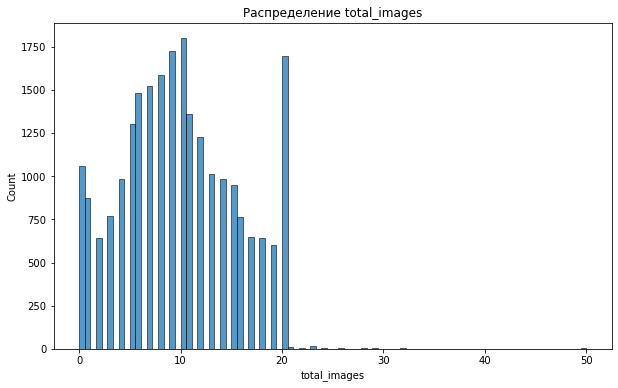

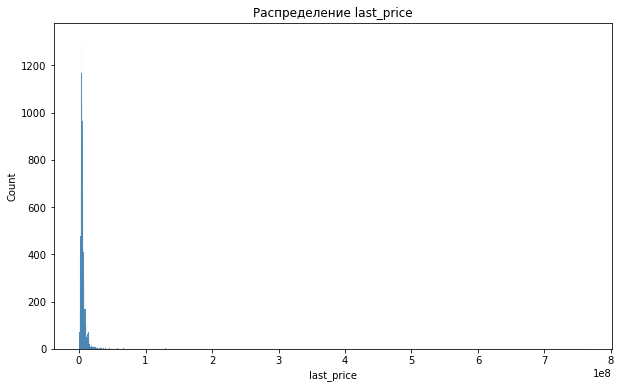

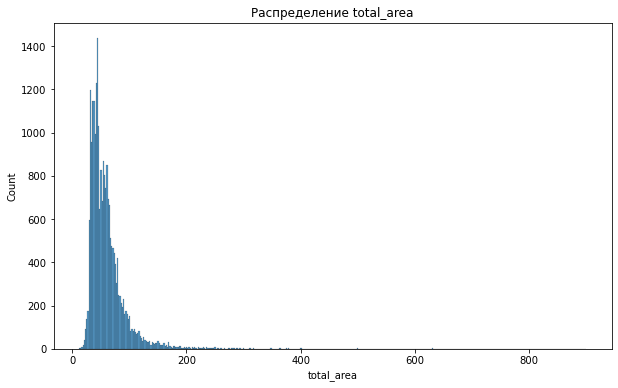

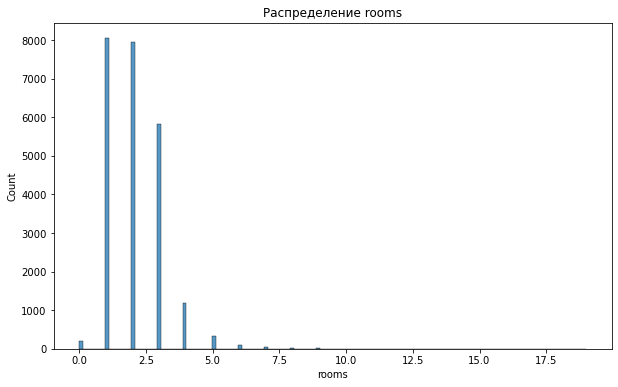

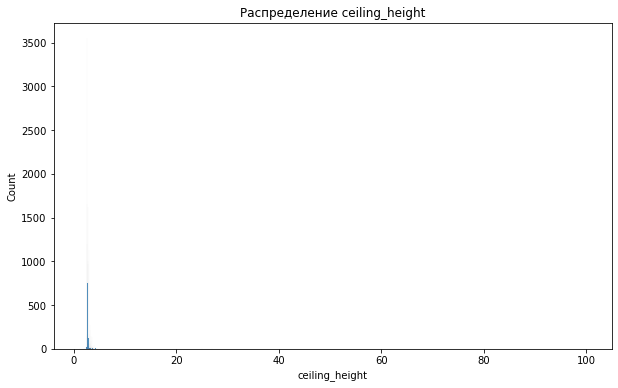

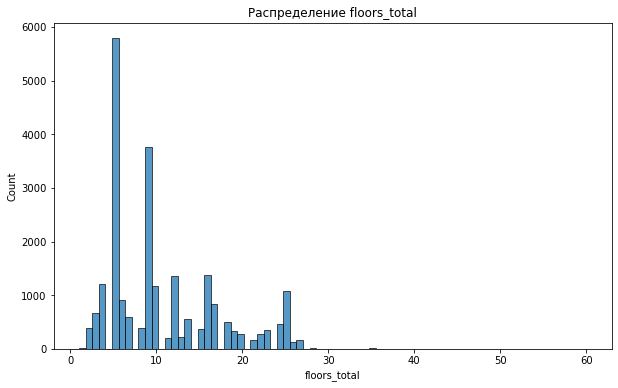

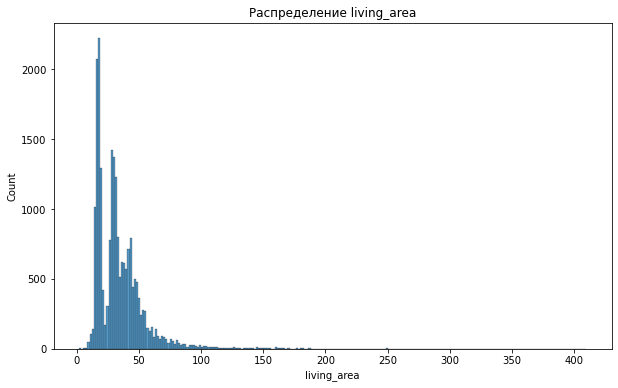

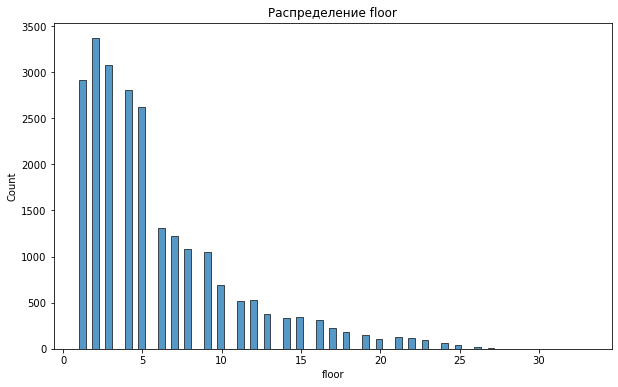

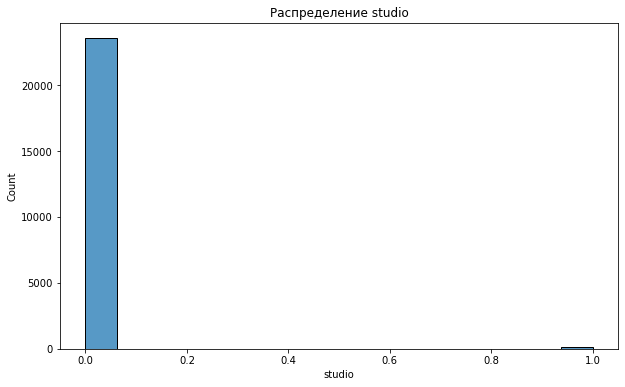

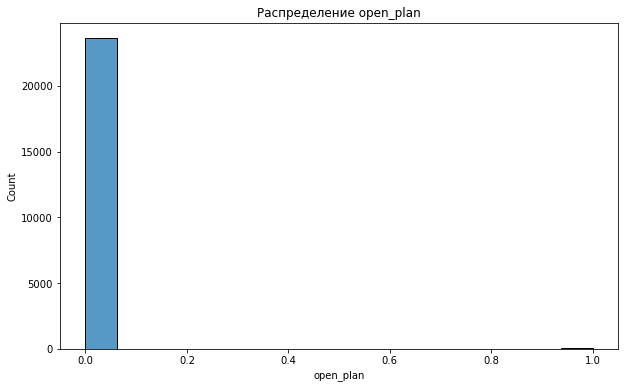

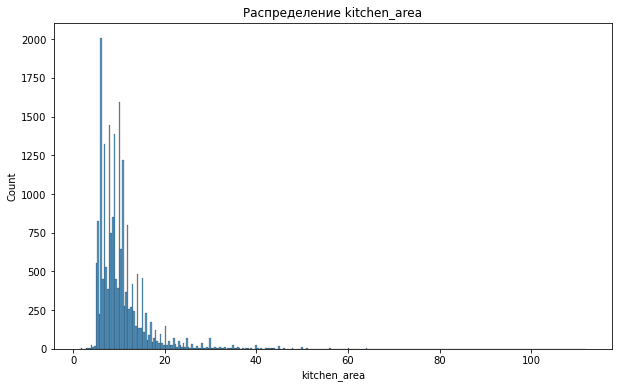

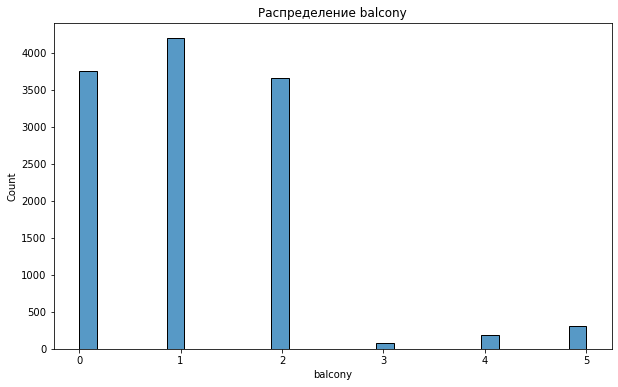

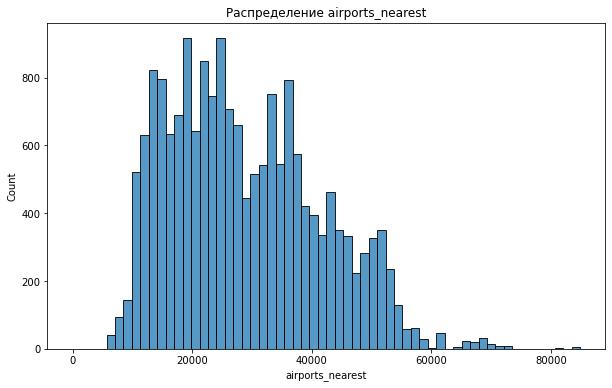

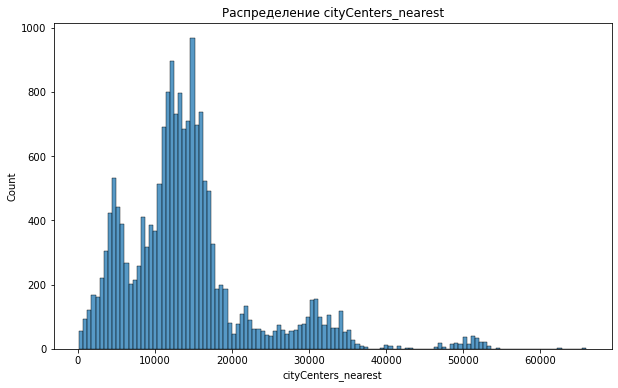

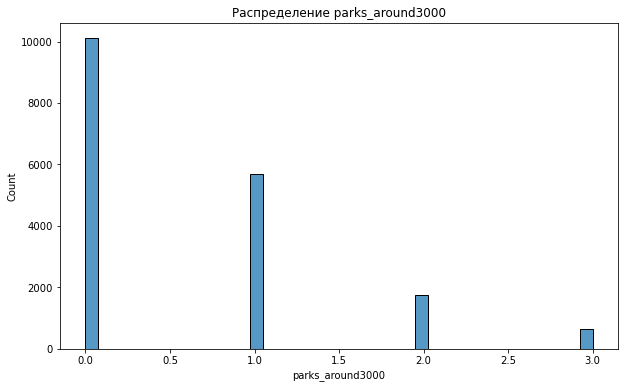

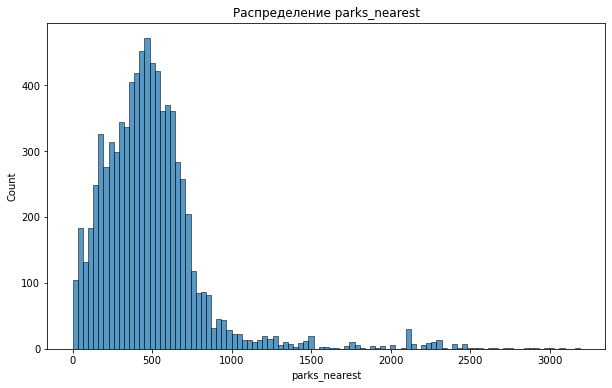

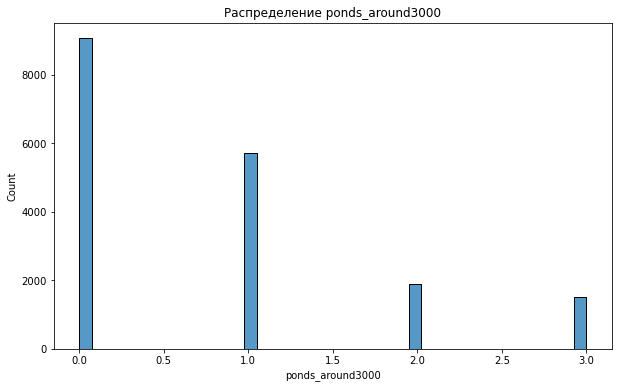

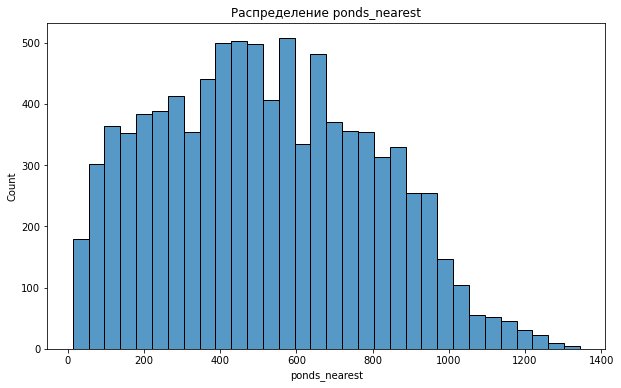

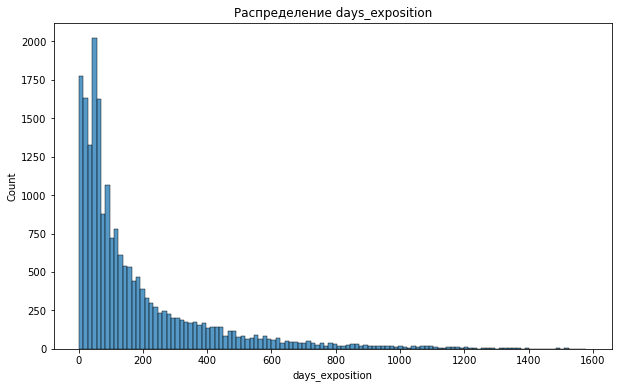

In [3]:
def info(data):

    """
    Функция пробегает по признакам датафрейма и если тип у признака object, то смотрит уникальные значения, в противном случае 
    оценивается распределение
    """
    
    for column in data.columns:
    
        if data[column].dtype == 'object':
            
            print(column)
            print(data[column].unique())
            print()
            print(data[column].describe())
            print()
            
            
        else:
            
            print(column)
            print(data[column].describe())
            plt.figure(figsize=(10, 6))
            sns.histplot(data[column])
            plt.title('Распределение '+ column);
            
info(real_estate_df)

Аномальные значения заметны в столбце "высота потолков", особенно выдаёт их то, что есть скопление выбросов в районе 25 метров, что больше похоже на ошибку при постановке десятичной запятой, так как самая популярная высота 2.48 - 2.52 м. Соответственно <span style="color:red">необходимо</span> их обработать, а также рассмотреть очень низкие потолки (ниже 2.2 м) и с высотой 20 и 100 м, правда, эти высоты также могут быть связаны с описанной выше ошибкой. Также стоит проверить объявления с нулём комнат, с количеством балконов выше трёх и очень дешёвые квартиры.  
В названиях населённых пунктов могут скрываться неявные дубликаты (уже видны "поселок" и "посёлок"), <span style="color:red">необходимо</span> будет проверить и обработать их.

### Вывод

* Исходный набор данных представляет собой таблицу, состоящую из 22 столбцов-признаков и 23699 строк.
* Названия столбцов не совсем корректны:
    * название столбца 'cityCenters_nearest' выбивается из общего стиля
    * названия столбцов 'studio' и 'open_plan' логически не подходят под тип данных 'bool'
* Типы данных требуют более детального анализа и переопределения.
* Часть данных явно пропущена, есть столбцы, в которых большая часть - пропуски, что скорее всего указывает на отсутствие данного признака в записях.
* Заметны аномальные значения в столбце "высота потолков":
    * сверхвысокие потолки (>14 м), что похоже на ошибку при постановке десятичной запятой
    * неестественно низкие потолки (<2.2 м)
* Также стоит проверить объявления с нулём комнат, с количеством балконов больше трёх.
* В столбце "населённый пункт" заметно рассогласование при заполнении поля: в одних записях "посёлок", в других - "поселок", возможно наличие опечаток (но маловероятно).

<a id="data_preprocessing"></a>
### Шаг 2. Предобработка данных

<a id="column_renaming"></a>
### Переименование столбцов

Переименуем столбцы в соответствии с содержимым и принятым стилем.

In [4]:
real_estate_df.columns = (
    real_estate_df
    .columns
    .to_series() # преобразуем индексы столбцов в тип Series()
    .replace('studio', 'is_studio')
    .replace('open_plan', 'is_open_plan')
    .replace('cityCenters_nearest', 'city_centers_nearest')
    .to_list()
)

real_estate_df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'is_studio', 'is_open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

<a id="missing_values"></a>
### Обработка пропущенных значений

Рассмотрим пропуски чуть детальнее. Для этого выведем столбцы и процент пропущенных данных и тепловую карту пропусков в датафрейме.

ceiling_height - 38.8%
floors_total - 0.4%
living_area - 8.0%
is_apartment - 88.3%
kitchen_area - 9.6%
balcony - 48.6%
locality_name - 0.2%
airports_nearest - 23.4%
city_centers_nearest - 23.3%
parks_around3000 - 23.3%
parks_nearest - 65.9%
ponds_around3000 - 23.3%
ponds_nearest - 61.6%
days_exposition - 13.4%


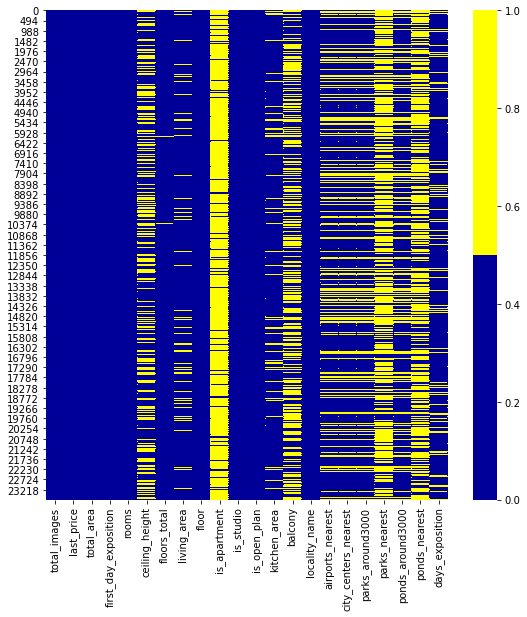

In [5]:
colours = ['#000099', '#ffff00']
plt.figure(figsize=(9, 9))
sns.heatmap(real_estate_df.isnull(), cmap=sns.color_palette(colours))

for col in real_estate_df.columns:
    pct_missing = real_estate_df[col].isnull().mean()
    if pct_missing > 0:
        print('{} - {:.1%}'.format(col, pct_missing))

Разберёмся со столбцом 'is_apartment'. Не похоже, что пропуски связаны с другими признаками, а скорее просто являются не указанным значением, что можно заменить на False.

In [6]:
real_estate_df['is_apartment'] = real_estate_df['is_apartment'].fillna(False).astype('bool')
print(real_estate_df['is_apartment'].dtype)
real_estate_df['is_apartment'].describe()

bool


count     23699
unique        2
top       False
freq      23649
Name: is_apartment, dtype: object

Теперь перейдём к столбцу "расстояние до ближайшего парка". Посмотрим, связано ли отсутствие информации о расстоянии до ближайшего парка с отсутствием таковых в радиусе 3 километров.

In [10]:
# def custom_query(df: pd.DataFrame, query_text: str):
#     """
#     Возвращает срез датафрейма с помощью запроса. При возникновении ошибки типа меняет движок запроса на 'python'.
#     """
#     original_query = pd.DataFrame.query
    
#     try:
#         return df.query(query_text)
#     except TypeError:
#         pd.DataFrame.query = partialmethod(pd.DataFrame.query, engine='python')
        
#         result = df.query(query_text)
#         pd.DataFrame.query = original_query
#         return result

In [11]:
(
    real_estate_df
    .query('parks_nearest.isnull() and not parks_around3000.isnull()')['parks_around3000']
    .describe()
)

count    10102.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: parks_around3000, dtype: float64

Как видно, можно быть увереным на 100%, что отсутствие расстояния до ближайшего парка связано с отсутствием парков в радиусе 3 км.  
Ту же гипотезу проверим и для расстояния до ближайшего водоёма.

In [12]:
(
    real_estate_df
    .query('ponds_nearest.isnull() and not ponds_around3000.isnull()')['ponds_around3000']
    .describe()
)

count    9071.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: ponds_around3000, dtype: float64

Как видно, и тут гипотеза полностью подтвердилась. Значит, можно и нужно сохранить эти пропущенные значения, так как они напрямую связаны с другими столбцами: отсутствие расстояния до ближайшего парка связано с отсутствием парков в радиусе 3 км, а отсутствие расстояния до ближайшего водоёма связано с отсутствием водоёмов в радиусе 3 км.  
Теперь удобно проанализировать пропущенные значения в столбцах с количеством парков и водоёмов в радиусе 3 км.

In [13]:
(
    real_estate_df
    .query('parks_around3000.isnull()')['parks_nearest']
    .unique()
)

array([nan])

Очевидна полная взаимосвязь признаков: если отсутствует информация о расстоянии до ближайшего парка, то парков в радиусе 3 км нет, и наоборот - если данных о числе парков нет, а значит, можно смело ставить 0, то и расстояние до ближайшего парка не указано.

In [14]:
real_estate_df['parks_around3000'].fillna(0, inplace=True)
real_estate_df['parks_around3000'].describe()

count    23699.000000
mean         0.469049
std          0.748534
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

In [15]:
(
    real_estate_df
    .query('ponds_around3000.isnull()')['ponds_nearest']
    .unique()
)

array([nan])

Здесь аналогичный вывод и следствие из него: если данных о числе водоёмов нет, значит, можно смело ставить 0.

In [16]:
real_estate_df['ponds_around3000'].fillna(0, inplace=True)
real_estate_df['ponds_around3000'].describe()

count    23699.000000
mean         0.590911
std          0.883999
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

Теперь посмотрим на записи, в которых не указано количество балконов.

In [17]:
real_estate_df.query('balcony.isnull()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,False,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,False,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,False,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,0.0,NaN,0.0,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,False,...,8.81,NaN,посёлок Мурино,NaN,NaN,0.0,NaN,0.0,NaN,189.0
10,5,5050000.0,39.60,2017-11-16T00:00:00,1,2.67,12.0,20.30,3,False,...,8.50,NaN,Санкт-Петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5.0,17.50,4,False,...,6.00,NaN,Тихвин,NaN,NaN,0.0,NaN,0.0,NaN,413.0
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.30,3,False,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.00,4,False,...,8.50,NaN,Тосно,NaN,NaN,0.0,NaN,0.0,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.70,1,False,...,NaN,NaN,село Рождествено,NaN,NaN,0.0,NaN,0.0,NaN,NaN


Вряд ли отстутствие информации о количестве балконов связано с другими признаками, а просто говорит об отсутствии балкона. Поэтому заменим NaN на нули.

Записей, в которых отсутствует информация о числе балконов: 0


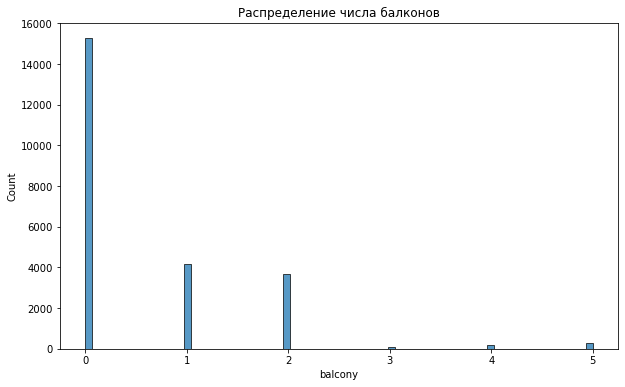

In [18]:
real_estate_df['balcony'].fillna(0, inplace=True)
print('Записей, в которых отсутствует информация о числе балконов:', real_estate_df['balcony'].isnull().sum())

plt.figure(figsize=(10, 6))
sns.histplot(real_estate_df['balcony'])
plt.title('Распределение числa балконов');

Теперь попробуем обработать пропуски в столбце "населённый пункт". Можно с большой долей уверенности утверждать, что, имея данные о расстоянии до центра города и до ближайшего аэропорта, а также числе парков и водоёмов в радиусе 3 км, можно определить населённый пункт. Выведем все объявления, где имеется информация о растоянии до центра города и до ближайшего аэропорта, с числом парков и водоёмов.

In [19]:
filtered_data = real_estate_df.query('locality_name.isnull() and\
        not city_centers_nearest.isnull() and not airports_nearest.isnull()')\
        [['city_centers_nearest', 'airports_nearest', 'parks_around3000', 'ponds_around3000']]
filtered_data

,city_centers_nearest,airports_nearest,parks_around3000,ponds_around3000
1097,4258.0,23478.0,0.0,0.0
2603,17369.0,22041.0,0.0,1.0
2632,17369.0,22041.0,0.0,1.0
3574,8127.0,27419.0,0.0,1.0
4151,3902.0,25054.0,1.0,3.0
4189,3039.0,21774.0,1.0,1.0
4670,5382.0,26534.0,1.0,1.0
5343,9538.0,10556.0,1.0,0.0
5707,16788.0,21460.0,0.0,1.0
6765,17369.0,22041.0,0.0,1.0


Проведём поиск наиболее вероятных н.п., в которых находятся соответствующие квартиры.

In [20]:
def define_probable_locality(source_df, target_row, city_precision, airport_precision, use_parks_and_ponds=True):
    
    """
    Функция ищет населённый пункт, в котором вероятнее всего находится дом и квартира, к которой относится данное объявление.
    Поиск происходит среди похожих объявлений: разность расстояний до ближайшего аэропорта и до центра города между
    объявлениями в source_df и целевым объявлением target_row не превышает заданных значений
    (city_precision и airport_precision, соответственно), число парков и водоёмов в радиусе 3 км
    равно числу таковых в целевом объявлении.
    Если записей, соответствующих запросу, нет, то происходит поиск без учёта наличия парков и водоёмов и
    с удвоением максимальной разности расстояний до ближайшего аэропорта и до центра города, пока одна из разностей
    не превысит 10 км.
    
    Аргументы:
        source_df - датафрейм с объявлениями
        target_row - целевое объявление, в котором не указан населённый пункт
        city_precision - максимальная разность расстояний до центра города
        airport_precision - максимальная разность расстояний до ближайшего аэропорта
        use_parks_and_ponds - использовать число парков и водоёмов в радиусе 3 км при поиске или нет
        
    Возвращает моду из списка н.п., которые удовлетворили запросу или NaN, если н.п. не был определён.
    
    """
    
    query_text = 'abs(city_centers_nearest - @target_row.city_centers_nearest) <= @city_precision and \
            abs(airports_nearest - @target_row.airports_nearest) <= @airport_precision'
    
    if use_parks_and_ponds:
        query_text += ' and parks_around3000 == @target_row.parks_around3000 and \
                ponds_around3000 == @target_row.ponds_around3000'
    
    try:
        filter_result = source_df.query(query_text)
    except Exception as e:
        print('While doing a query next error has happened:', e, '\n', type(e), file=sys.stderr)
        return np.nan
    
    if not filter_result['locality_name'].value_counts().empty:
        probable_locality = filter_result.query('not locality_name.isnull()')['locality_name'].mode().values[0]
    elif city_precision < 10**4 and airport_precision < 10**4:
        probable_locality = define_probable_locality(source_df, target_row, city_precision*2, airport_precision*2,
                                                     use_parks_and_ponds=False)
    else:
        probable_locality = np.nan
    
    return probable_locality


city_centers_nearest_precision = 500
airports_nearest_precision = 500
locality_list = []

for index in filtered_data.index:
    row = filtered_data.loc[index, :]
    probable_locality = define_probable_locality(real_estate_df, row, city_centers_nearest_precision,
                                                 airports_nearest_precision)
    locality_list.append(probable_locality)
    
filtered_data['probable_locality'] = locality_list
filtered_data

,city_centers_nearest,airports_nearest,parks_around3000,ponds_around3000,probable_locality
1097,4258.0,23478.0,0.0,0.0,Санкт-Петербург
2603,17369.0,22041.0,0.0,1.0,Санкт-Петербург
2632,17369.0,22041.0,0.0,1.0,Санкт-Петербург
3574,8127.0,27419.0,0.0,1.0,Санкт-Петербург
4151,3902.0,25054.0,1.0,3.0,Санкт-Петербург
4189,3039.0,21774.0,1.0,1.0,Санкт-Петербург
4670,5382.0,26534.0,1.0,1.0,Санкт-Петербург
5343,9538.0,10556.0,1.0,0.0,Санкт-Петербург
5707,16788.0,21460.0,0.0,1.0,Санкт-Петербург
6765,17369.0,22041.0,0.0,1.0,Санкт-Петербург


Видно, что большая часть из этих объявлений скорее всего относятся к Санкт-Петербургу.  
Заполним пропуски в real_estate_df, используя столбец с возможным местоположением и проверим, сколько записей без н.п. осталось.

In [21]:
real_estate_df.loc[filtered_data.index, 'locality_name'] = filtered_data['probable_locality']
print('Записей, в которых отсутствует информация о н.п.:', real_estate_df['locality_name'].isnull().sum())

Записей, в которых отсутствует информация о н.п.: 8


Выведем записи без н.п.

In [22]:
print('Доля записей без н.п.: {:.3%}'.format(real_estate_df['locality_name'].isnull().mean()))
real_estate_df.query('locality_name.isnull()')

Доля записей без н.п.: 0.034%


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2033,6,5398000.0,80.0,2017-05-30T00:00:00,3,NaN,4.0,42.6,2,False,...,18.6,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,34.0
14342,3,3611000.0,53.5,2017-04-27T00:00:00,1,NaN,4.0,25.8,3,False,...,NaN,1.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,92.0
17535,2,5985000.0,79.8,2018-07-30T00:00:00,3,NaN,9.0,NaN,2,False,...,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,213.0
20382,8,1750000.0,72.9,2018-10-27T00:00:00,3,NaN,5.0,47.3,2,False,...,8.3,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
20590,7,3380000.0,56.0,2017-11-06T00:00:00,2,2.7,4.0,29.0,3,False,...,10.0,1.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,78.0
21715,2,6047550.0,80.1,2018-07-30T00:00:00,2,NaN,9.0,30.5,2,False,...,29.2,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,176.0
21898,2,5886750.0,83.5,2018-07-30T00:00:00,2,NaN,9.0,36.6,2,False,...,29.7,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,169.0
22717,9,3000000.0,35.0,2018-01-02T00:00:00,1,2.6,16.0,16.0,7,False,...,10.0,1.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,75.0


Заметно отсутствие информации как о расстоянию до центра города, так и до ближайшего аэропорта. Так как записей всего 8, что составляет чуть больше 0.03% от всех записей, то удаление не скажется на дальнейшем анализе.

In [23]:
real_estate_df.dropna(subset=['locality_name'], inplace=True)
print('Записей, в которых отсутствует информация о н.п.:', real_estate_df['locality_name'].isnull().sum())

Записей, в которых отсутствует информация о н.п.: 0


Теперь проанализируем записи, в которых не указаны расстояния до центра города и/или до ближайшего аэропорта.

In [24]:
print(
    'Записей, где не указано расстояние до ближайшего аэропорта:',
    len(real_estate_df.query('airports_nearest.isnull() and not city_centers_nearest.isnull()'))
)
print(
    real_estate_df
    .query('airports_nearest.isnull() and not city_centers_nearest.isnull()')['locality_name']
    .value_counts(), '\n')
print(
    'Записей, где не указано расстояние до центра города:',
    len(real_estate_df.query('not airports_nearest.isnull() and city_centers_nearest.isnull()'))
)
print(
    real_estate_df
    .query('not airports_nearest.isnull() and city_centers_nearest.isnull()')['locality_name']
    .value_counts(), '\n')
print(
    'Число записей, в которых одновременно пропущены значения расстояния до ближайшего аэропорта и до центра города:',
    len(real_estate_df.query('airports_nearest.isnull() and city_centers_nearest.isnull()'))
)
print(real_estate_df.query('airports_nearest.isnull() and city_centers_nearest.isnull()')['locality_name'].value_counts())

Записей, где не указано расстояние до ближайшего аэропорта: 24
Санкт-Петербург    24
Name: locality_name, dtype: int64 

Записей, где не указано расстояние до центра города: 1
Пушкин    1
Name: locality_name, dtype: int64 

Число записей, в которых одновременно пропущены значения расстояния до ближайшего аэропорта и до центра города: 5510
посёлок Мурино                     522
Всеволожск                         398
Гатчина                            307
деревня Кудрово                    299
Выборг                             237
                                  ... 
деревня Большая Пустомержа           1
поселок Возрождение                  1
деревня Борисова Грива               1
посёлок Форт Красная Горка           1
посёлок Платформа 69-й километр      1
Name: locality_name, Length: 344, dtype: int64


Для 24 записей из Санкт-Петербурга попробуем определить примерное расстояние до ближайшего аэропорта, используя информацию о расстоянии до центра города и числе парков и водоёмов в радиусе 3 км (логика похожа на определение вероятного местоположения).

In [25]:
filtered_data = real_estate_df.query('not city_centers_nearest.isnull() and airports_nearest.isnull()')\
        [['city_centers_nearest', 'parks_around3000', 'ponds_around3000', 'locality_name']]
filtered_data

,city_centers_nearest,parks_around3000,ponds_around3000,locality_name
733,13355.0,1.0,0.0,Санкт-Петербург
974,9734.0,2.0,3.0,Санкт-Петербург
2415,13355.0,1.0,0.0,Санкт-Петербург
7521,5735.0,2.0,0.0,Санкт-Петербург
7542,13355.0,1.0,0.0,Санкт-Петербург
8018,5735.0,2.0,0.0,Санкт-Петербург
8628,5735.0,2.0,0.0,Санкт-Петербург
9054,9734.0,2.0,3.0,Санкт-Петербург
9880,4892.0,0.0,2.0,Санкт-Петербург
10669,21377.0,0.0,0.0,Санкт-Петербург


In [35]:
city_centers_nearest_precision = 100
airports_nearest_list = []

pd.DataFrame.query = partialmethod(pd.DataFrame.query, engine="python")

for index in filtered_data.index:
    row = filtered_data.loc[index, :]
    filter_result = (
        real_estate_df
        .query('abs(city_centers_nearest - @row.city_centers_nearest) <= @city_centers_nearest_precision and \
                parks_around3000 == @row.parks_around3000 and ponds_around3000 == @row.ponds_around3000 and \
                locality_name == @row.locality_name',
               local_dict={
                   'row': row,
                   'city_centers_nearest_precision': city_centers_nearest_precision
               })
    )
    if not filter_result.empty:
        median_distance = filter_result['airports_nearest'].median()
    else:
        median_distance = np.nan
    airports_nearest_list.append(median_distance)
    
filtered_data['airports_nearest'] = airports_nearest_list
cols = filtered_data.columns.tolist()
cols = [cols[0], cols[-1], *cols[1:-1]]
filtered_data = filtered_data[cols]
filtered_data

,city_centers_nearest,airports_nearest,parks_around3000,ponds_around3000,locality_name
733,13355.0,7233.0,1.0,0.0,Санкт-Петербург
974,9734.0,35923.5,2.0,3.0,Санкт-Петербург
2415,13355.0,7233.0,1.0,0.0,Санкт-Петербург
7521,5735.0,26038.5,2.0,0.0,Санкт-Петербург
7542,13355.0,7233.0,1.0,0.0,Санкт-Петербург
8018,5735.0,26038.5,2.0,0.0,Санкт-Петербург
8628,5735.0,26038.5,2.0,0.0,Санкт-Петербург
9054,9734.0,35923.5,2.0,3.0,Санкт-Петербург
9880,4892.0,25987.0,0.0,2.0,Санкт-Петербург
10669,21377.0,18230.0,0.0,0.0,Санкт-Петербург


In [42]:
real_estate_df.loc[filtered_data.index, 'airports_nearest'] = filtered_data['airports_nearest']
print(
    'Записей, где не указано расстояние до ближайшего аэропорта:',
    len(real_estate_df.query('airports_nearest.isnull() and not city_centers_nearest.isnull()'))
)

Записей, где не указано расстояние до ближайшего аэропорта: 0


Для остальных записей заполним пропуски медианными значениями расстояний для каждого н.п., но перед этим придётся обработать неявные дубликаты в столбце "населённый пункт", так как записей достаточно много и отследить корректность подсчёта медианы будет достаточно сложно. Искать неявные дубликаты будем с помощью подсчёта минимального расстояния редактирования Левенштейна: расстояние, равное "1", соответствует, например, словам "поселок" и "посёлок" - таким образом, искать будем дубликаты с расстоянием Левенштейна не больше "2" (максимум две опечатки).

In [43]:
real_estate_df['locality_name'].isnull().sum()

0

In [44]:
import nltk


def find_implicit_duplicates(data):
    data = set(data)
    implicit_duplicates = [
        [
            value2
            for value2 in list(data - set([value1]))
            if nltk.edit_distance(value1, value2) < 3 and value2 != ''
        ]
        for value1 in data
    ]
    
    implicit_duplicates = [
        item[0]
        for item in implicit_duplicates
        if len(item) != 0
    ]
    
    print('Всего неявных дубликатов выявлено:', len(implicit_duplicates))
    print('\nСписок неявных дубликатов:\n', implicit_duplicates)
    return implicit_duplicates

    
locality_implicit_duplicates = find_implicit_duplicates(real_estate_df['locality_name'])

Всего неявных дубликатов выявлено: 79

Список неявных дубликатов:
 ['поселок городского типа Красный Бор', 'поселок Семрино', 'посёлок Новый Свет', 'посёлок Гаврилово', 'посёлок городского типа Рябово', 'посёлок Поляны', 'городской посёлок Янино-1', 'посёлок Тельмана', 'посёлок Стеклянный', 'поселок Старая Малукса', 'посёлок Старая Малукса', 'деревня Калитино', 'посёлок Мичуринское', 'посёлок городского типа Форносово', 'поселок Стеклянный', 'посёлок Аннино', 'поселок Перово', 'поселок Поляны', 'поселок Ильичёво', 'посёлок городского типа Вырица', 'поселок городского типа Кузьмоловский', 'городской поселок Янино-1', 'посёлок Усть-Луга', 'поселок Победа', 'посёлок Жилгородок', 'деревня Тарасово', 'поселок Мичуринское', 'посёлок Петровское', 'посёлок Сумино', 'поселок городского типа имени Свердлова', 'посёлок городского типа имени Свердлова', 'посёлок городского типа Рощино', 'посёлок Пансионат Зелёный Бор', 'посёлок Терволово', 'поселок городского типа Лебяжье', 'посёлок Мельниково', '

Как видим, основное число дубликатов связано с несогласованной постановкой / непостановкой "ё" в слове "посёлок", остальные случаи, похоже ложны, так как и деревня Куровицы и Курковицы существуют и находятся в Ленинградской области. Отберем такие случаи для того, чтобы наверняка удостовериться.

In [45]:
import re


others_list = []
for locality in locality_implicit_duplicates:
    if not re.search('пос[её]лок', locality):
        others_list.append(locality)
others_list

['деревня Калитино',
 'деревня Тарасово',
 'деревня Курковицы',
 'деревня Рапполово',
 'деревня Лупполово',
 'деревня Куровицы',
 'деревня Кальтино',
 'деревня Торосово']

Данные деревни реально существуют и находятся в Ленинградской области, поэтому не будем их трогать. Остаётся заменить "посёлок" на "поселок", так как в данном случае непостановка "ё" не повлияет на смысл слова и его восприятие.

In [46]:
real_estate_df['locality_name'] = real_estate_df['locality_name'].replace({'посёлок': 'поселок'}, regex=True)
real_estate_df['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'городской поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет

Заполним пропуски медианными значениями расстояний для каждого н.п., перед этим отфильтровав записи без расстояния до центра города, куда войдут и записи, где одновременно отсутствуют и расстояние до центра, и расстояние до ближайшего аэропорта.

In [47]:
filtered_data = real_estate_df.query('city_centers_nearest.isnull()')['locality_name']
filtered_data

5        городской поселок Янино-1
8                   поселок Мурино
12                       Сертолово
22                 деревня Кудрово
30                        Коммунар
                   ...            
23683         поселок Дзержинского
23692                       Тихвин
23695                        Тосно
23696             село Рождествено
23698          поселок Новый Учхоз
Name: locality_name, Length: 5511, dtype: object

In [49]:
for locality in filtered_data.unique():
    filter_result = (
        real_estate_df
        .query('locality_name == @locality', local_dict={'locality': locality})['city_centers_nearest']
    )
    
    if not filter_result.empty:
        city_centers_nearest_median = filter_result.median()
    
        if not pd.isnull(city_centers_nearest_median):
            (
                real_estate_df
                .loc[real_estate_df['locality_name'] == locality, 'city_centers_nearest']
                .fillna(city_centers_nearest_median, inplace=True)
            )
            
print(
    'Записей, где не указано расстояние до центра города:',
    real_estate_df['city_centers_nearest'].isnull().sum()
)

Записей, где не указано расстояние до центра города: 5511


Число не изменилось, значит, для большого числа небольших н.п. не указано расстояние до центра города. Попробуем заполнить пропуски расстояний до ближайшего аэропорта таким же способом.

In [50]:
filtered_data = real_estate_df.query('airports_nearest.isnull()')['locality_name']
filtered_data

5        городской поселок Янино-1
8                   поселок Мурино
12                       Сертолово
22                 деревня Кудрово
30                        Коммунар
                   ...            
23683         поселок Дзержинского
23692                       Тихвин
23695                        Тосно
23696             село Рождествено
23698          поселок Новый Учхоз
Name: locality_name, Length: 5510, dtype: object

In [51]:
for locality in filtered_data.unique():
    airports_nearest_median = (
        real_estate_df
        .query('locality_name == @locality', local_dict={'locality': locality})['airports_nearest'].median()
    )
    
    if not pd.isnull(airports_nearest_median):
        (
            real_estate_df
            .loc[real_estate_df['locality_name'] == locality, 'airports_nearest']
            .fillna(airports_nearest_median, inplace=True)
        )
print(
    'Записей, где не указано расстояние до ближайшего аэропорта:',
    real_estate_df['airports_nearest'].isnull().sum()
)

Записей, где не указано расстояние до ближайшего аэропорта: 5510


Число не изменилось, значит, для большого числа небольших н.п. не указано расстояние до ближайшего аэропорта. Удалять записи без расстояния до центра города и до ближайшего аэропорта не стоит, так как доля таких записей больше 20% от всего числа записей, поэтому сохраним данные записи.

Теперь проанализируем и обработаем пропуски в столбце "площадь кухни".

In [52]:
filtered_data = real_estate_df.query('kitchen_area.isnull()')
filtered_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,False,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,NaN,9.0,NaN,2,False,...,NaN,0.0,Коммунар,NaN,NaN,0.0,NaN,0.0,NaN,63.0
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.50,5.0,NaN,1,False,...,NaN,0.0,поселок городского типа Красный Бор,NaN,NaN,0.0,NaN,0.0,NaN,196.0
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,NaN,22.0,NaN,3,False,...,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
59,15,6300000.0,46.5,2017-03-06T00:00:00,1,NaN,13.0,NaN,13,False,...,NaN,0.0,Санкт-Петербург,11125.0,14501.0,0.0,NaN,0.0,NaN,336.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23655,1,2414306.0,40.5,2016-09-08T00:00:00,1,2.56,18.0,19.6,10,False,...,NaN,0.0,Никольское,NaN,NaN,0.0,NaN,0.0,NaN,627.0
23663,12,6400000.0,88.0,2018-01-12T00:00:00,4,2.55,10.0,NaN,1,False,...,NaN,0.0,Санкт-Петербург,33642.0,13943.0,0.0,NaN,2.0,844.0,59.0
23670,9,2450000.0,45.6,2018-02-08T00:00:00,1,2.80,9.0,NaN,2,False,...,NaN,0.0,поселок городского типа Синявино,NaN,NaN,0.0,NaN,0.0,NaN,45.0
23679,0,2500000.0,35.0,2017-12-08T00:00:00,1,NaN,9.0,NaN,4,False,...,NaN,0.0,Сосновый Бор,NaN,NaN,0.0,NaN,0.0,NaN,45.0


Заменим пропуски там, где это можно, на медиану площади кухни из объявлений того же н.п. с таким же числом комнат и разностью между полными площадями не более 5 кв.м.

In [53]:
def calculate_kitchen_area(source_df, target_row, area_precision, use_locality=True, use_rooms=True):
    
    """
    Функция ищет площадь кухни квартиры, к которой относится данное объявление, путём вычисления медианной площади
    из похожих объявлений: из того же н.п., разность площадей кухни между
    объявлениями в source_df и целевым объявлением target_row не превышает заданных значений
    (area_precision), с таким же числом комнат.
    Если записей, соответствующих запросу, нет, то происходит поиск без учёта числа комнат.
    Если и таких записей не окажется, то происходит поиск и без учёта н.п.
    
    Аргументы:
        source_df - датафрейм с объявлениями
        target_row - целевое объявление, в котором не указан населённый пункт
        area_precision - максимальная разность площадей кухни
        use_locality - использовать информацию о н.п. при поиске или нет
        use_rooms - использовать число комнат при поиске или нет
        
    Возвращает медианную площадь из объявлений, которые удовлетворили запросу или NaN, если таких объявлений не найдено.
    
    """
    
    query_text = 'abs(total_area - @target_row.total_area) <= @area_precision'
    
    if use_locality:
        query_text += ' and locality_name == @target_row.locality_name'
        
    if use_rooms:
        query_text += ' and rooms == @target_row.rooms'
    
    filter_result = source_df.query(query_text, local_dict={'target_row': target_row, 'area_precision': area_precision})
    
    if not filter_result.empty:
        kitchen_area_median = filter_result['kitchen_area'].median()
    
    if not pd.isnull(kitchen_area_median):
        median_area = kitchen_area_median
    elif use_rooms:
        median_area = calculate_kitchen_area(source_df, target_row, area_precision, use_rooms=False)
    elif use_locality:
        median_area = calculate_kitchen_area(source_df, target_row, area_precision, use_locality=False, use_rooms=False)
    else:
        median_area = np.nan
    
    return median_area


total_area_precision = 5
kitchen_area_median_list = []

for index in filtered_data.index:
    row = filtered_data.loc[index, :]
    median_area = calculate_kitchen_area(real_estate_df, row, total_area_precision)
    kitchen_area_median_list.append(median_area)
    
filtered_data.loc[:, 'kitchen_area'] = kitchen_area_median_list
print(
    'Записей в отфильтрованном датафрейме, где не указана площадь кухни:',
    filtered_data['kitchen_area'].isnull().sum()
)

Записей в отфильтрованном датафрейме, где не указана площадь кухни: 1


C:\ProgramData\Anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [54]:
filtered_data.query('kitchen_area.isnull()')['rooms'].value_counts()

5    1
Name: rooms, dtype: int64

Таким образом, необработанной осталась 1 запись с пятикомнатной квартирой.  
Заполним пропуски в исходном датафрейме, необработанную запись удалим.

In [55]:
real_estate_df.loc[filtered_data.index, 'kitchen_area'] = filtered_data['kitchen_area']
real_estate_df.dropna(subset=['kitchen_area'], inplace=True)
print(
    'Записей, где не указана площадь кухни:',
    real_estate_df['kitchen_area'].isnull().sum()
)

Записей, где не указана площадь кухни: 0


Таким же образом обработаем пропуски в столбце "жилая площадь" с условием, что сумма жилой площади и площади кухни не может быть больше общей площади.

In [56]:
filtered_data = real_estate_df.query('living_area.isnull()')
filtered_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,False,...,22.00,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,False,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,NaN,9.0,NaN,2,False,...,7.10,0.0,Коммунар,NaN,NaN,0.0,NaN,0.0,NaN,63.0
37,10,1990000.0,45.80,2017-10-28T00:00:00,2,2.50,5.0,NaN,1,False,...,7.70,0.0,поселок городского типа Красный Бор,NaN,NaN,0.0,NaN,0.0,NaN,196.0
44,13,5350000.0,40.00,2018-11-18T00:00:00,1,NaN,22.0,NaN,3,False,...,10.00,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23642,14,5950000.0,80.30,2018-07-03T00:00:00,3,2.70,12.0,NaN,5,False,...,9.65,0.0,Колпино,27933.0,33719.0,0.0,NaN,2.0,562.0,60.0
23663,12,6400000.0,88.00,2018-01-12T00:00:00,4,2.55,10.0,NaN,1,False,...,10.00,0.0,Санкт-Петербург,33642.0,13943.0,0.0,NaN,2.0,844.0,59.0
23670,9,2450000.0,45.60,2018-02-08T00:00:00,1,2.80,9.0,NaN,2,False,...,11.80,0.0,поселок городского типа Синявино,NaN,NaN,0.0,NaN,0.0,NaN,45.0
23679,0,2500000.0,35.00,2017-12-08T00:00:00,1,NaN,9.0,NaN,4,False,...,8.00,0.0,Сосновый Бор,NaN,NaN,0.0,NaN,0.0,NaN,45.0


In [57]:
def calculate_living_area(source_df, target_row, area_precision, use_locality=True, use_rooms=True):
    
    """
    Функция ищет жилую площадь квартиры, к которой относится данное объявление, путём вычисления медианной площади
    из похожих объявлений: из того же н.п., разность жилых площадей между
    объявлениями в source_df и целевым объявлением target_row не превышает заданных значений
    (area_precision), с таким же числом комнат.
    Если записей, соответствующих запросу, нет, то происходит поиск без учёта числа комнат.
    Если и таких записей не окажется, то происходит поиск и без учёта н.п.
    
    Аргументы:
        source_df - датафрейм с объявлениями
        target_row - целевое объявление, в котором не указан населённый пункт
        area_precision - максимальная разность жилых площадей
        use_locality - использовать информацию о н.п. при поиске или нет
        use_rooms - использовать число комнат при поиске или нет
        
    Возвращает медианную площадь из объявлений, которые удовлетворили запросу, если сумма жилой площади и кухни
    не превышает общую площадь, иначе  если площадь кухни меньше общей, то возвращается разность общей площади и
    площади кухни, иначе NaN; если таких объявлений не найдено, то возвращает NaN.
    
    """
    
    query_text = 'abs(total_area - @target_row.total_area) <= @area_precision'
    
    if use_locality:
        query_text += ' and locality_name == @target_row.locality_name'
        
    if use_rooms:
        query_text += ' and rooms == @target_row.rooms'
    
    filter_result = source_df.query(query_text, local_dict={'target_row': target_row, 'area_precision': area_precision})
    
    if not filter_result.empty:
        living_area_median = filter_result['living_area'].median()
    
    if not pd.isnull(living_area_median):
        if target_row['kitchen_area'] + living_area_median <= target_row['total_area']:
            median_area = living_area_median
        elif target_row['kitchen_area'] < target_row['total_area']:
            median_area = target_row['total_area'] - target_row['kitchen_area']
        else:
            median_area = np.nan
    elif use_rooms:
        median_area = calculate_living_area(source_df, target_row, area_precision, use_rooms=False)
    elif use_locality:
        median_area = calculate_living_area(source_df, target_row, area_precision, use_locality=False, use_rooms=False)
    else:
        median_area = np.nan
    
    return median_area


total_area_precision = 5
living_area_median_list = []

for index in filtered_data.index:
    row = filtered_data.loc[index, :]
    median_area = calculate_living_area(real_estate_df, row, total_area_precision)
    living_area_median_list.append(median_area)
    
filtered_data.loc[:, 'living_area'] = living_area_median_list
print(
    'Записей в отфильтрованном датафрейме, где не указана жилая площадь:',
    filtered_data['living_area'].isnull().sum()
)

Записей в отфильтрованном датафрейме, где не указана жилая площадь: 1


C:\ProgramData\Anaconda\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Таким образом, необработанной осталась 1 запись.  
Заполним пропуски в исходном датафрейме, необработанные записи удалим.

In [58]:
real_estate_df.loc[filtered_data.index, 'living_area'] = filtered_data['living_area']
real_estate_df.dropna(subset=['living_area'], inplace=True)
print(
    'Записей, где не указана жилая площадь:',
    real_estate_df['living_area'].isnull().sum()
)

Записей, где не указана жилая площадь: 0


Теперь обработаем пропуски в столбце "всего этажей". Проанализируем данные записи.

In [59]:
real_estate_df.query('floors_total.isnull()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02T00:00:00,2,NaN,NaN,30.80,4,False,...,12.00,0.0,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,NaN,NaN,20.75,1,False,...,6.50,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01T00:00:00,2,NaN,NaN,38.40,12,False,...,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06T00:00:00,3,NaN,NaN,47.10,8,False,...,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22T00:00:00,1,NaN,NaN,18.00,9,False,...,10.00,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000.0,63.5,2017-05-24T00:00:00,2,2.8,NaN,33.60,3,False,...,11.60,0.0,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
22656,4,4574160.0,64.5,2017-04-02T00:00:00,2,NaN,NaN,31.70,20,False,...,14.40,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22808,0,14569263.0,110.4,2016-11-20T00:00:00,3,NaN,NaN,45.38,6,False,...,23.42,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0
23590,0,21187872.0,123.3,2017-04-25T00:00:00,3,NaN,NaN,50.40,18,False,...,23.60,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0


Этажи, на которых расположена квартира указаны. Можно попробовать заполнить пропуски модой из объявлений того же дома, главное - проверить, что число этажей в доме не меньше этажа в данном объявлении.  
Не везде может иметься информация о расстоянии до центра города и ближайшего аэропорта, поэтому учтём это в функции.

In [60]:
def define_floor_num(source_df, target_row, city_precision=0, airport_precision=0,
                     use_distances=True, use_parks_and_ponds=True):
    
    """
    Функция ищет этажность дома, к которому относится данное объявление, путём вычисления моды этажностей
    из объявлений по соседству: из того же н.п., разность расстояний до ближайшего аэропорта и до центра города между
    объявлениями в source_df и целевым объявлением target_row не превышает заданных значений
    (city_precision и airport_precision, соответственно), число парков и водоёмов в радиусе 3 км
    равно числу таковых в целевом объявлении.
    Если записей, соответствующих запросу, нет, то происходит поиск без учёта наличия парков и водоёмов
    с увеличением радиуса поиска в два раза.
    Если и таковых не окажется, то ищется мода среди всех объявлений данного города и этажности не ниже указанного в объявлении
    этажа.
    
    Аргументы:
        source_df - датафрейм с объявлениями
        target_row - целевое объявление, в котором не указан населённый пункт
        city_precision - максимальная разность расстояний до центра города
        airport_precision - максимальная разность расстояний до ближайшего аэропорта
        use_distances - использовать расстояния до центра города и до ближайшего аэропорта при поиске или нет
        use_parks_and_ponds - использовать число парков и водоёмов в радиусе 3 км при поиске или нет
        
    Возвращает моду этажностей из объявлений, которые удовлетворили запросу или NaN, если таких объявлений не найдено.
    
    """
    
    query_text = 'locality_name == @target_row.locality_name and floors_total >= @target_row.floor'
    
    if use_distances:
        query_text += ' and abs(city_centers_nearest - @target_row.city_centers_nearest) <= @city_precision and \
            abs(airports_nearest - @target_row.airports_nearest) <= @airport_precision'
    
    if use_parks_and_ponds:
        query_text += ' and parks_around3000 == @target_row.parks_around3000 and \
                ponds_around3000 == @target_row.ponds_around3000'
    
    try:
        filter_result = source_df.query(query_text, local_dict={
            'target_row': target_row,
            'city_precision': city_precision,
            'airport_precision': airport_precision
        })
    except Exception as e:
        print('While doing a query next error has happened:', e, '\n', type(e), file=sys.stderr)
        return np.nan
    
    if not filter_result['floors_total'].value_counts().empty:
        floors_total = filter_result['floors_total'].mode().values[0]
            
    elif use_parks_and_ponds:
        floors_total = define_floor_num(source_df, target_row, city_precision*2, airport_precision*2,
                                        use_parks_and_ponds=False)
    elif use_distances:
        floors_total = define_floor_num(source_df, target_row, use_distances=False, use_parks_and_ponds=False)
    else:
        floors_total = np.nan
    
    return floors_total


filtered_data = real_estate_df.query('floors_total.isnull()')

city_centers_nearest_precision = 10
airports_nearest_precision = 10
floors_total_list = []

for index in filtered_data.index:
    row = filtered_data.loc[index, :]
    floors_total = define_floor_num(real_estate_df, row, city_centers_nearest_precision, airports_nearest_precision)
    floors_total_list.append(floors_total)
    
filtered_data['floors_total'] = floors_total_list
print(
    'Записей в отфильтрованном датафрейме, где не указано число этажей в доме:',
    filtered_data['floors_total'].isnull().sum()
)

Записей в отфильтрованном датафрейме, где не указано число этажей в доме: 0


<ipython-input-60-92d2d7e073bf>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['floors_total'] = floors_total_list


Заполним пропуски в исходном датафрейме.

In [61]:
real_estate_df.loc[filtered_data.index, 'floors_total'] = filtered_data['floors_total']
print(
    'Записей, где не указано число этажей в доме:',
    real_estate_df['floors_total'].isnull().sum()
)

Записей, где не указано число этажей в доме: 0


Посмотрим записи, в которых не указано, сколько дней было размещено объявление.

In [62]:
real_estate_df.query('days_exposition.isnull()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,36.6,22,False,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
44,13,5350000.0,40.00,2018-11-18T00:00:00,1,NaN,22.0,18.0,3,False,...,10.00,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
45,17,5200000.0,50.60,2018-12-02T00:00:00,2,2.65,9.0,30.3,7,False,...,7.00,0.0,Санкт-Петербург,30011.0,12872.0,0.0,NaN,0.0,NaN,NaN
46,17,6600000.0,52.10,2019-01-31T00:00:00,2,2.60,24.0,29.7,9,False,...,8.30,2.0,Санкт-Петербург,15114.0,12702.0,0.0,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23684,20,21400000.0,145.00,2018-11-02T00:00:00,4,3.00,26.0,71.4,17,False,...,15.60,0.0,Санкт-Петербург,11827.0,11459.0,0.0,NaN,0.0,NaN,NaN
23685,15,2490000.0,31.00,2019-01-24T00:00:00,1,2.50,5.0,17.3,5,False,...,5.60,1.0,Ломоносов,48393.0,51818.0,0.0,NaN,0.0,NaN,NaN
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,False,...,13.83,0.0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,False,...,8.30,0.0,село Рождествено,NaN,NaN,0.0,NaN,0.0,NaN,NaN


Скорее всего, данные объявления не были сняты, поэтому и нет информации о числе дней, в течение которых оно было размещено на сайте. Тогда введём столбец, в котором пометим снятые объявления.

In [63]:
real_estate_df['is_sold'] = ~real_estate_df['days_exposition'].isnull()
real_estate_df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,is_sold
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,False
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,...,2.0,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,True
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,False,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,True
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,88.0,9,False,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,True
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,True


Теперь проанализируем записи, в которых не указана высота потолка.

In [64]:
real_estate_df.query('ceiling_height.isnull()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,is_sold
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,...,2.0,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,True
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,False,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,True
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,88.0,9,False,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,True
5,10,2890000.0,30.4,2018-09-10T00:00:00,1,NaN,12.0,14.4,5,False,...,0.0,городской поселок Янино-1,NaN,NaN,0.0,NaN,0.0,NaN,55.0,True
6,6,3700000.0,37.3,2017-11-02T00:00:00,1,NaN,26.0,10.6,6,False,...,1.0,поселок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23687,6,3200000.0,39.0,2017-12-16T00:00:00,1,NaN,9.0,20.0,6,False,...,2.0,Санкт-Петербург,40837.0,16704.0,0.0,NaN,0.0,NaN,38.0,True
23690,3,5500000.0,52.0,2018-07-19T00:00:00,2,NaN,5.0,31.0,2,False,...,0.0,Санкт-Петербург,20151.0,6263.0,1.0,300.0,0.0,NaN,15.0,True
23692,2,1350000.0,30.0,2017-07-07T00:00:00,1,NaN,5.0,17.5,4,False,...,0.0,Тихвин,NaN,NaN,0.0,NaN,0.0,NaN,413.0,True
23695,14,3100000.0,59.0,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,False,...,0.0,Тосно,NaN,NaN,0.0,NaN,0.0,NaN,45.0,True


Попробуем обработать данные пропуски тем же методом, что и пропуски этажности дома. Но перед этим уберём аномально большие значения из предположения, что сверхвысокие потолки - следствие неправильной постановки десятичной запятой.

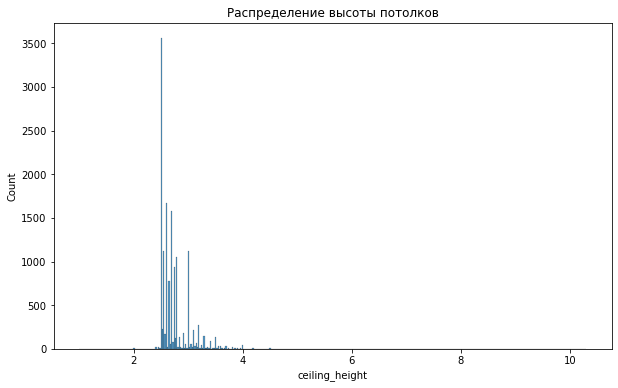

In [65]:
real_estate_df.loc[real_estate_df['ceiling_height'] > 10.3, 'ceiling_height'] *= 0.1

plt.figure(figsize=(10, 6))
sns.histplot(
    real_estate_df,
    x='ceiling_height'
)
plt.title('Распределение высоты потолков');

In [73]:
def define_ceiling_height(source_df, target_row, city_precision=0, airport_precision=0, use_distances=True,
                          use_parks_and_ponds=True, use_floors_total=False, use_locality=True):
    
    """
    Функция ищет высоту потолков квартиры путём вычисления моды высоты потолков из объявлений по соседству
    (желательно из того же дома): из того же н.п., разность расстояний до ближайшего аэропорта и до центра города между
    объявлениями в source_df и целевым объявлением target_row не превышает заданных значений
    (city_precision и airport_precision, соответственно), число парков и водоёмов в радиусе 3 км
    равно числу таковых в целевом объявлении.
    Если записей, соответствующих запросу, нет, то происходит поиск без учёта наличия парков и водоёмов
    с увеличением радиуса поиска в два раза.
    Если и таковых не окажется, то ищется мода среди всех объявлений данного города и с той же этажностью,
    иначе мода ищется среди всех объявлений с той же этажностью.
    
    Аргументы:
        source_df - датафрейм с объявлениями
        target_row - целевое объявление, в котором не указан населённый пункт
        city_precision - максимальная разность расстояний до центра города
        airport_precision - максимальная разность расстояний до ближайшего аэропорта
        use_distances - использовать расстояния до центра города и до ближайшего аэропорта при поиске или нет
        use_parks_and_ponds - использовать число парков и водоёмов в радиусе 3 км при поиске или нет
        use_floors_total - использовать число этажей в доме при поиске или нет
        use_locality - искать в данном н.п. или по всем записям
        
    Возвращает моду этажностей из объявлений, которые удовлетворили запросу или NaN, если таких объявлений не найдено.
    
    """
    
    query_text = 'ceiling_height >= 2.5'
    
    if use_distances:
        query_text += ' and abs(city_centers_nearest - @target_row.city_centers_nearest) <= @city_precision and \
            abs(airports_nearest - @target_row.airports_nearest) <= @airport_precision'
    
    if use_parks_and_ponds:
        query_text += ' and parks_around3000 == @target_row.parks_around3000 and \
                ponds_around3000 == @target_row.ponds_around3000'
        
    if use_floors_total:
        query_text += ' and floors_total == @target_row.floors_total'
        
    if use_locality:
        query_text += ' and locality_name == @target_row.locality_name'
    
    try:
        filter_result = source_df.query(query_text, local_dict={
            'target_row': target_row,
            'city_precision': city_precision,
            'airport_precision': airport_precision
        })
    except Exception as e:
        print('While doing a query next error has happened:', e, '\n', type(e), file=sys.stderr)
        return np.nan
    
    if not filter_result['ceiling_height'].value_counts().empty:
        ceiling_height = filter_result['ceiling_height'].mode().values[0]
            
    elif use_parks_and_ponds:
        ceiling_height = define_ceiling_height(source_df, target_row, city_precision*2, airport_precision*2,
                                               use_parks_and_ponds=False)
    elif use_distances:
        ceiling_height = define_ceiling_height(source_df, target_row, use_distances=False, use_parks_and_ponds=False)
        
    elif use_locality:
        ceiling_height = define_ceiling_height(source_df, target_row, use_distances=False, use_parks_and_ponds=False,
                                               use_locality=False, use_floors_total=True)
    else:
        ceiling_height = np.nan
    
    return ceiling_height


filtered_data = real_estate_df.query('ceiling_height.isnull()')

city_centers_nearest_precision = 10
airports_nearest_precision = 10
ceiling_height_list = []

for index in filtered_data.index:
    row = filtered_data.loc[index, :]
    ceiling_height = define_ceiling_height(real_estate_df, row, city_centers_nearest_precision,
                                                 airports_nearest_precision)
    ceiling_height_list.append(ceiling_height)
    
filtered_data['ceiling_height'] = ceiling_height_list
print(
    'Записей в отфильтрованном датафрейме, где не указана высота потолков:',
    filtered_data['ceiling_height'].isnull().sum()
)

Записей в отфильтрованном датафрейме, где не указана высота потолков: 0


<ipython-input-73-3d6d4db4d695>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['ceiling_height'] = ceiling_height_list


Заполним пропуски в исходном датафрейме.

In [74]:
real_estate_df.loc[filtered_data.index, 'ceiling_height'] = filtered_data['ceiling_height']
print(
    'Записей, где не указана высота потолков:',
    real_estate_df['ceiling_height'].isnull().sum()
)

Записей, где не указана высота потолков: 0


<a id="data_typization"></a>
### Замена типов

Приведём дату размещения объявления к удобочитаемой форме.

In [75]:
real_estate_df['first_day_exposition'] = pd.to_datetime(real_estate_df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
real_estate_df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,corresponds_to_building regulations,floors_total,living_area,floor,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,is_sold
0,20,13000000.0,108.0,2019-03-07,3,2.70,True,16,51.0,8,...,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,False
1,7,3350000.0,40.4,2018-12-04,1,2.60,False,11,18.6,1,...,2,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,True
2,10,5196000.0,56.0,2015-08-20,2,2.50,False,5,34.3,4,...,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,True
3,0,64900000.0,159.0,2015-07-24,3,3.00,False,14,88.0,9,...,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,True
4,2,10000000.0,100.0,2018-06-19,2,3.03,True,14,32.0,13,...,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,True


Приведём столбцы "всего этажей", "число балконов", "число парков в радиусе 3 км" и "число водоёмов в радиусе 3 км" к целочисленному типу, так как это целочисленные величины.

In [76]:
real_estate_df = real_estate_df.astype(
    {
        'floors_total': int,
        'balcony': int,
        'parks_around3000': int,
        'ponds_around3000': int
    }
)
real_estate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23689 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   total_images                         23689 non-null  int64         
 1   last_price                           23689 non-null  float64       
 2   total_area                           23689 non-null  float64       
 3   first_day_exposition                 23689 non-null  datetime64[ns]
 4   rooms                                23689 non-null  int64         
 5   ceiling_height                       23689 non-null  float64       
 6   corresponds_to_building regulations  23689 non-null  bool          
 7   floors_total                         23689 non-null  int32         
 8   living_area                          23689 non-null  float64       
 9   floor                                23689 non-null  int64         
 10  is_apartme

In [99]:
bool_cols = [i for i, dtype in zip(real_estate_df.dtypes.index, real_estate_df.dtypes) if str(dtype) == 'bool']
type_dict = {col: int for col in bool_cols}

real_estate_df = real_estate_df.astype(type_dict)
real_estate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23689 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   total_images                         23689 non-null  int64         
 1   last_price                           23689 non-null  float64       
 2   total_area                           23689 non-null  float64       
 3   first_day_exposition                 23689 non-null  datetime64[ns]
 4   rooms                                23689 non-null  int64         
 5   ceiling_height                       23689 non-null  float64       
 6   is_sold                              23689 non-null  int32         
 7   corresponds_to_building regulations  23689 non-null  int32         
 8   floors_total                         23689 non-null  int32         
 9   living_area                          23689 non-null  float64       
 10  floor     

<a id="anomalies"></a>
### Обработка аномалий

Рассмотрим объявления с очень низкими потолками (ниже 2.2 м).

In [100]:
real_estate_df.query('ceiling_height < 2.2')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,is_sold,corresponds_to_building regulations,floors_total,living_area,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
552,11,2999000.0,33.50,2017-03-30,1,2.00,1,0,15,17.5,...,6.50,0,Санкт-Петербург,33972.0,11746.0,1,520.0,1,949.0,270.0
2572,4,2400000.0,62.00,2018-12-27,3,2.00,0,0,5,40.0,...,6.00,1,Луга,NaN,NaN,0,NaN,0,NaN,NaN
4212,1,2120000.0,35.43,2017-12-18,1,2.00,1,0,18,16.6,...,8.80,2,Тосно,NaN,NaN,0,NaN,0,NaN,36.0
5712,5,1500000.0,42.80,2017-08-14,2,1.20,1,0,2,27.5,...,5.20,0,городской поселок Мга,NaN,NaN,0,NaN,0,NaN,248.0
5850,9,1650000.0,35.50,2018-05-29,1,2.00,1,0,5,17.0,...,8.60,0,Луга,NaN,NaN,0,NaN,0,NaN,100.0
11352,4,3300000.0,36.00,2017-06-18,1,2.00,1,0,17,15.2,...,10.10,0,поселок Металлострой,25268.0,26980.0,0,NaN,0,NaN,53.0
15061,19,5600000.0,56.40,2018-05-11,2,1.40,1,0,14,32.4,...,9.10,2,Санкт-Петербург,14814.0,13610.0,0,NaN,0,NaN,315.0
16446,6,12300000.0,88.30,2019-03-12,3,2.00,0,0,5,63.9,...,12.00,0,Санкт-Петербург,38415.0,7675.0,1,568.0,1,154.0,NaN
16884,0,1500000.0,33.00,2018-10-03,1,2.00,1,0,5,20.0,...,6.00,0,Выборг,NaN,NaN,0,NaN,0,NaN,6.0
16934,5,4100000.0,40.00,2017-10-17,1,1.75,1,0,37,17.4,...,8.34,0,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,71.0


Возможно, часть данных ошибочно введена, возможно, что где-то в деревне есть дома с потолками 2 метра, но вряд ли в многоэтажном доме потолки будут ниже 2.5, так как это минимальная высота согласно СНиПу. Пометим все записи, с высотой потолка ниже 2.5 м как не соответствующие СНиПу, а потом заменим высоту потолков в записях выше на моду высоты в соответствующем н.п.

In [78]:
real_estate_df['corresponds_to_building regulations'] = (real_estate_df['ceiling_height'] >= 2.5).astype(int)
cols = real_estate_df.columns.tolist()
cols = [*cols[:6], cols[-1], *cols[6:-1]]
real_estate_df = real_estate_df[cols]
real_estate_df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,is_sold,corresponds_to_building regulations,floors_total,living_area,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,False,1,16,51.0,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.60,True,1,11,18.6,...,11.0,2,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.50,True,1,5,34.3,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,3.00,True,1,14,88.0,...,22.0,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,True,1,14,32.0,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0


In [101]:
filtered_data = real_estate_df.query('ceiling_height < 2.2')

ceiling_height_list = []

for index in filtered_data.index:
    row = filtered_data.loc[index, :]
    filter_result = real_estate_df.query('locality_name == @row.locality_name and ceiling_height >= 2.5',
                                         local_dict={'row': row})
    
    if not filter_result['ceiling_height'].value_counts().empty:
        ceiling_height = filter_result['ceiling_height'].mode().values[0]
    else:
        filter_result = real_estate_df.query('floors_total == @row.floors_total and ceiling_height >= 2.5',
                                             local_dict={'row': row})
        
        if not filter_result['ceiling_height'].value_counts().empty:
            ceiling_height = filter_result['ceiling_height'].mode().values[0]
        
    ceiling_height_list.append(ceiling_height)
    
filtered_data['ceiling_height'] = ceiling_height_list

<ipython-input-101-efb6659096fb>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['ceiling_height'] = ceiling_height_list


Обновим датафрейм и посмотрим на распределение высоты потолков.

C:\ProgramData\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


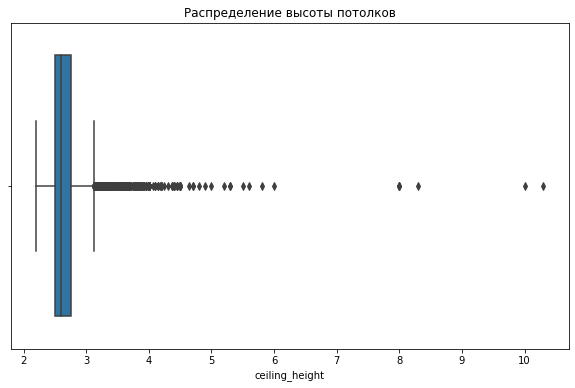

In [111]:
real_estate_df.loc[filtered_data.index, 'ceiling_height'] = filtered_data['ceiling_height']

plt.figure(figsize=(10, 6))
sns.boxplot(real_estate_df['ceiling_height'])
plt.title('Распределение высоты потолков');

Теперь больше похоже на правду.  
Разберёмся с записями, в которых число комнат равно 0. Построим гистограммы частот для записей с числом комнат меньше 4.

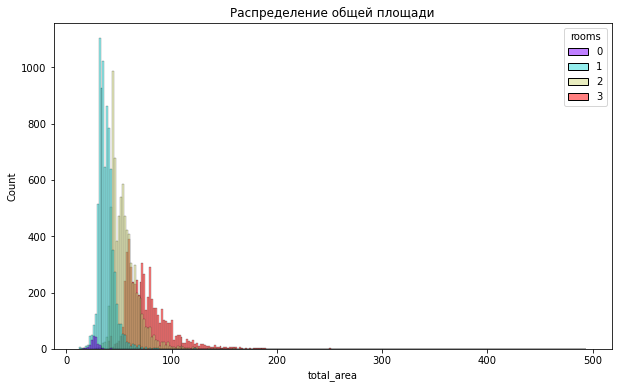

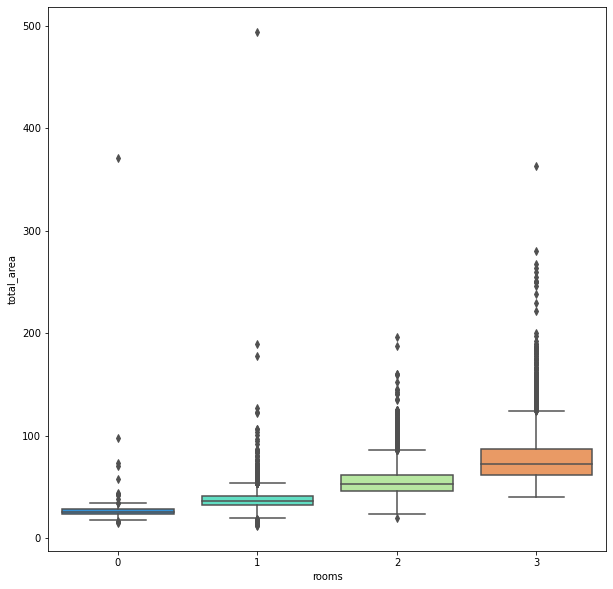

In [132]:
plt.figure(figsize=(10, 6))
sns.histplot(
    real_estate_df.query('rooms < 4'),
    x='total_area',
    hue='rooms',
    hue_order={'rooms': range(4)},
    palette='rainbow'
)
plt.title('Распределение общей площади');

plt.figure(figsize=(10, 10))
sns.boxplot(x='rooms', y='total_area', data=real_estate_df.query('rooms < 4'), palette='rainbow');

Видно, что большая часть из квартир с нулём комнат на самом деле относятся к однокомнатным, отдельные выбросы можно отнести к двухкомнатным и трёхкомнатным квартирам. Обработку проведём так: квартиры с общей площадью до 46 кв.м отнесём к "однушкам", до 62 кв.м - к "двушкам, свыше 62 кв.м - к "трёшкам".

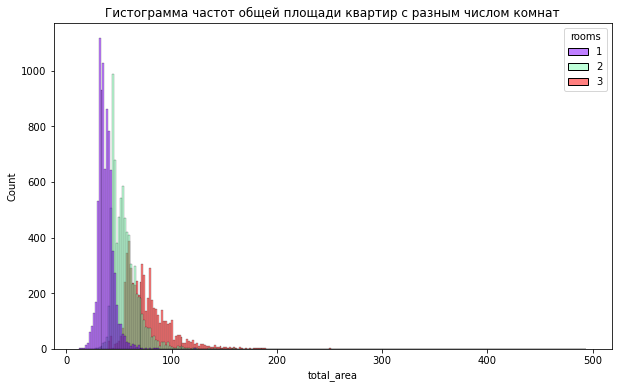

In [134]:
real_estate_df.loc[(real_estate_df['total_area'] <= 46) & (real_estate_df['rooms'] == 0), 'rooms'] = 1
real_estate_df.loc[(46 < real_estate_df['total_area']) & \
                   (real_estate_df['total_area'] <= 62) & \
                   (real_estate_df['rooms'] == 0), 'rooms'] = 2
real_estate_df.loc[(62 < real_estate_df['total_area']) & (real_estate_df['rooms'] == 0), 'rooms'] = 3

plt.figure(figsize=(10, 6))
sns.histplot(
    real_estate_df.query('rooms < 4'),
    x='total_area',
    hue='rooms',
    hue_order={'rooms': range(4)},
    palette='rainbow'
)
plt.title('Гистограмма частот общей площади квартир с разным числом комнат');

Всё равно остались подозрительно большие квартиры или дома. Обычно дома с такими площадями (от 150 кв.м) могут иметь 4, 5 и больше комнат.

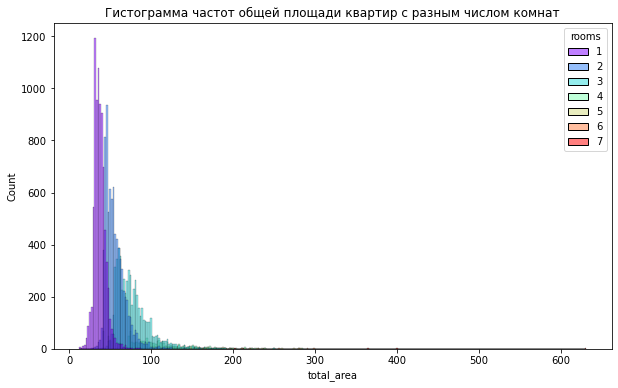

In [135]:
plt.figure(figsize=(10, 6))
sns.histplot(
    real_estate_df.query('rooms <= 7'),
    x='total_area',
    hue='rooms',
    hue_order={'rooms': range(8)},
    palette='rainbow'
)
plt.title('Гистограмма частот общей площади квартир с разным числом комнат');

Похоже, что либо это ошибки при вводе, либо кто-то хочет нас обмануть.
Проанализируем записи с тремя и более балконами, возможно, и здесь есть подвох.

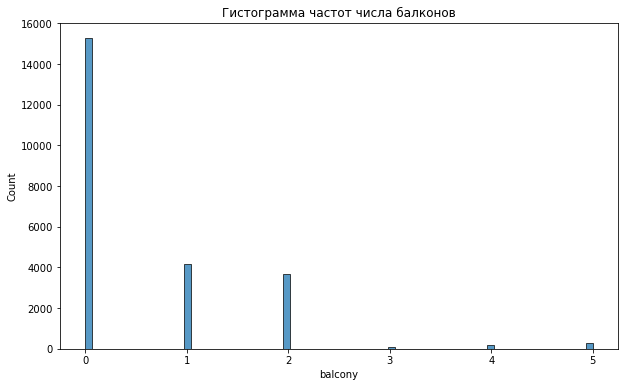

In [136]:
plt.figure(figsize=(10, 6))
sns.histplot(
    real_estate_df,
    x='balcony'
)
plt.title('Гистограмма частот числа балконов');

Немного странно, что среди объявлений с числом балконов больше 2 преобладают объявления с пятью балконами, а объявлений с 3 балконами меньше, чем с 4 или 5, хотя логика подсказывает, что должно быть наоборот.  
Осталось разобраться с подозрительно дешёвыми квартирами (<100k руб).

In [137]:
(
    real_estate_df
    .query('last_price <= 100000')[['last_price', 'locality_name', 'total_area', 'rooms', 'city_centers_nearest']]
)

,last_price,locality_name,total_area,rooms,city_centers_nearest
8793,12190.0,Санкт-Петербург,109.0,2,9176.0


Квартира находится в Петербурге, недалеко от центра, при этом стоит 12190 р. Цену вводил человек, значит, либо он ошибся при вводе, либо специально ввёл данное число. Посмотрим медианную цену 2х-комнатной квартиры в Питере с площадью от 100 до 120 кв.м.

In [138]:
(
    real_estate_df
    .query('locality_name == "Санкт-Петербург" and rooms == 2 and total_area >=100 and total_area <= 120')['last_price']
    .median()
)

16300000.0

Похоже, что реальная цена данной квартиры - 12190000 рублей.

In [139]:
real_estate_df.loc[real_estate_df['last_price'] < 100000, 'last_price'] *= 1000
real_estate_df[real_estate_df['last_price'] < 100000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,is_sold,corresponds_to_building regulations,floors_total,living_area,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


<a id="duplicates"></a>
### Обработка дубликатов

Неявные дубликаты, обнаруженные в столбце "населённый пункт", были обработаны, осталось проверить датафрейм на наличие записей-дубликатов.

In [140]:
real_estate_df.duplicated().sum()

0

### Вывод

1. Стобцы были переименованы в соответствии с содержимым и принятым стилем:
    1. 'cityCenters_nearest' -> 'city_centers_nearest'
    2. 'open_plan' -> 'is_open_plan', 'studio' -> 'is_studio'
2. Пропуски обработаны:
    1. В столбце 'is_apartment' заменены на False и тип приведён к 'bool'.
    2. В столбцах 'parks_nearest' и 'ponds_nearest' оставлены как есть, что означает отсутствие парков и водоёмов, соответственно, в радиусе 3 км.
    3. В столбцах 'parks_around3000' и 'ponds_around3000' заменены на 0.
    4. В столбце 'balcony' заменены на 0 из предположения, что неуказанное число балконов означает их отсутствие.
    5. В столбце 'locality_name' заменены на наиболее вероятный населённый пункт, который определялся по расстояниям до центра города и до ближайшего аэропорта, а также с учётом числа парков и водоёмов в радиусе 3 км. 8 записей, для которых не был найден населённый пункт, были удалены.
    6. В столбцах 'airports_nearest' и 'city_centers_nearest' заменены на медианы расстояний из ближайших объявлений при отсутствии информации только в одном столбце, а если информация отсутствовала в обоих столбцах, то на медианное расстояние для данного н.п., причём перед этим были обработаны неявные дубликаты в столбце 'locality_name' ("посёлок" заменён на "поселок"). Необработанные пропуски оставлены в датафрейме, т.к. их достаточно много.
    7. В столбце 'kitchen_area' заменены медианной площадью кухни из похожих объявлений, необработанные записи (1) удалены.
    8. В столбце 'living_area' заменены медианной площадью из похожих объявлений либо разностью площадей общей и кухонной, необработанные записи (1) удалены.
    9. В столбце 'floors_total' заменены на моду этажности ближайших объявлений.
    10. В столбце 'days_exposition' оставлены на своих местах в предположении, что данные квартиры не были проданы на момент выгрузки данных; введён столбец 'is_sold', в котором проданные квартиры отмечены True, остальные - False.
    11. В столбце 'ceiling_height' заменены на моду высоты потолков ближайших объявлений, перед этим аномально большие значения были уменьшены в 10 раз из предположения, что в данных ошиблись на один десятичный знак.
3. Выполнено приведение типов:
    1. Столбцы 'floors_total', 'balcony', 'parks_around3000' и 'ponds_around3000' приведены к целочисленному типу, так как это целочисленные величины.
    2. Дата размещения объявления 'first_day_exposition' приведена к типу 'datetime64'.
4. Обработаны аномалии:
    1. Записи с очень низкой высотой потолков (<2.2 м) заменены модами из объявлений того же н.п. или с тем же числом этажей.
    2. Записи с 0 комнат распределены на основе распределения площади по числу комнат на 1-о-, 2-х- и 3-х-комнатные квартиры.
    3. Аномально низкая цена в одной записи увеличена в 1000 раз на основании местоположения и площади квартиры.
5. Дубликатов найдено не было.

<a id="add_to_table"></a>
### Шаг 3. Посчитайте и добавьте в таблицу

Добавим цену квадратного метра, при этом округлим до двух десятичных знаков.

In [141]:
real_estate_df['cost_per_square_meter'] = round(real_estate_df['last_price'] / real_estate_df['total_area'], ndigits=2)

Добавим день недели, месяц и год публикации объявления.

In [142]:
real_estate_df['weekday_exposition'] = real_estate_df['first_day_exposition'].dt.weekday
real_estate_df['month_exposition'] = real_estate_df['first_day_exposition'].dt.month
real_estate_df['year_exposition'] = real_estate_df['first_day_exposition'].dt.year

Добавим этаж квартиры: первый, последний, другой.

In [143]:
def classify_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

real_estate_df['floor_class'] = real_estate_df[['floor', 'floors_total']].apply(classify_floor, axis=1)

Добавим соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [144]:
real_estate_df['living_total_area_proportion'] = real_estate_df['living_area'] / real_estate_df['total_area']
real_estate_df['kitchen_total_area_proportion'] = real_estate_df['kitchen_area'] / real_estate_df['total_area']
real_estate_df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,is_sold,corresponds_to_building regulations,floors_total,living_area,...,ponds_around3000,ponds_nearest,days_exposition,cost_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_class,living_total_area_proportion,kitchen_total_area_proportion
0,20,13000000.0,108.0,2019-03-07,3,2.70,0,1,16,51.0,...,2,755.0,NaN,120370.37,3,3,2019,другой,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,2.60,1,1,11,18.6,...,0,NaN,81.0,82920.79,1,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,2.50,1,1,5,34.3,...,2,574.0,558.0,92785.71,3,8,2015,другой,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24,3,3.00,1,1,14,88.0,...,3,234.0,424.0,408176.10,4,7,2015,другой,0.553459,0.138365
4,2,10000000.0,100.0,2018-06-19,2,3.03,1,1,14,32.0,...,1,48.0,121.0,100000.00,1,6,2018,другой,0.320000,0.410000


### Вывод

* Добавлена цену квадратного метра.
* Добавлены день недели, месяц и год публикации объявления.
* Добавлен этаж квартиры; варианты — первый, последний, другой.
* Добавлено соотношение жилой и общей площади, а также отношение площади кухни к общей.

<a id="explanatory_data_analysis"></a>
### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Изучим некоторые параметры квартир в объявлениях. Начнём с общей площади.

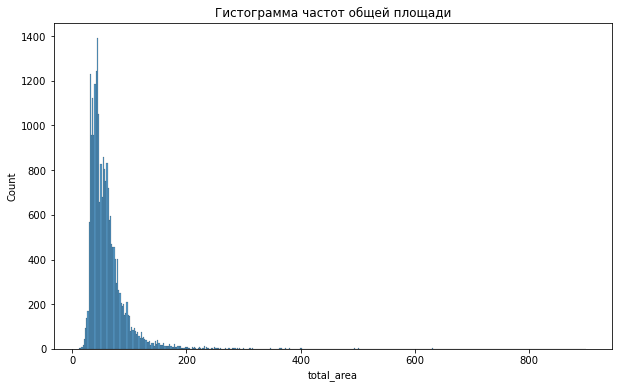

In [145]:
plt.figure(figsize=(10, 6))
sns.histplot(
    real_estate_df,
    x='total_area'
)
plt.title('Гистограмма частот общей площади');

Видим, что распределение ассиметрично и имеет тяжёлый "хвост" справа, 50% всех квартир имеет общую площадь от 40 до 69.8 кв.м, а самые редкие начинаются от 114.5 кв.м. Также заметны локальные максимумы частот, вокруг которых собраны наиболее распространённые значения площади для однокомнатных, двухкомнатных и трёхкомнатных квартир, что хорошо видно на следующей гистограмме.

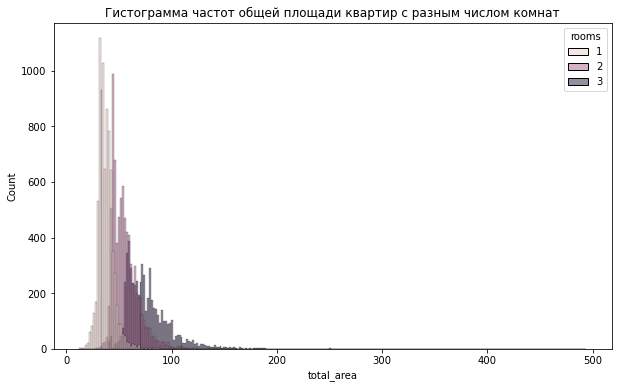

In [146]:
plt.figure(figsize=(10, 6))
sns.histplot(
    real_estate_df.query('rooms < 4'),
    x='total_area',
    hue='rooms',
    hue_order={'rooms': range(4)}
)
plt.title('Гистограмма частот общей площади квартир с разным числом комнат');

Теперь проанализируем цены на квартиры.

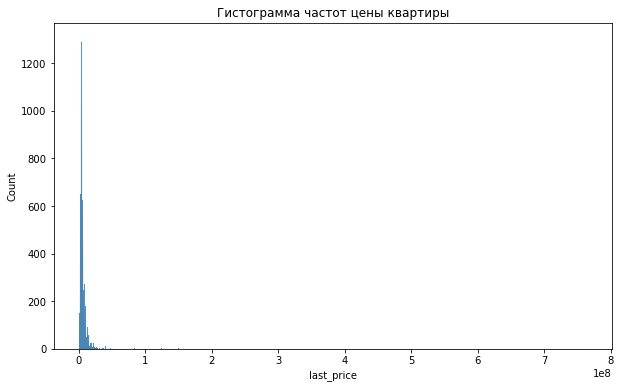

In [147]:
plt.figure(figsize=(10, 6))
sns.histplot(
    real_estate_df,
    x='last_price'
)
plt.title('Гистограмма частот цены квартиры');

Здесь также распределение ассиметрично и имеет тяжёлый "хвост". Большая часть квартир (>99%) находится в ценовом диапазоне 430 тыс. - 11.9 млн. рублей, при этом максимальная цена за квартиру составляет 763 млн. рублей.  
Посмотрим, как распределены объявления по числу комнат.

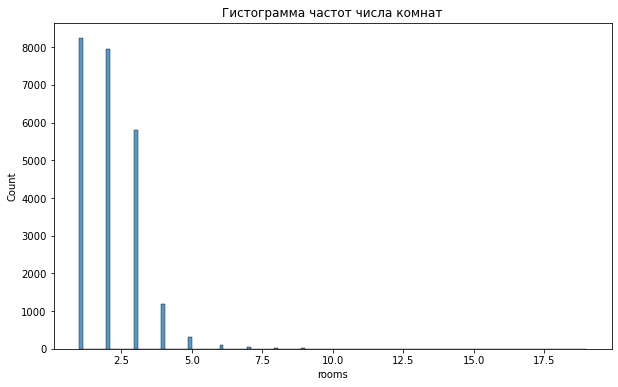

In [148]:
plt.figure(figsize=(10, 6))
sns.histplot(
    real_estate_df,
    x='rooms'
)
plt.title('Гистограмма частот числа комнат');

50% всех квартир - "однушки", "двушки" и "трёшки", очень редки квартиры с 7-ю комнатами и больше.  
Рассмотрим распределение высоты потолков.

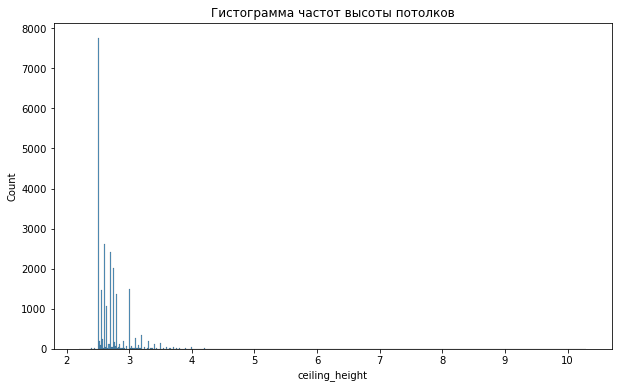

In [149]:
plt.figure(figsize=(10, 6))
sns.histplot(
    real_estate_df,
    x='ceiling_height'
)
plt.title('Гистограмма частот высоты потолков');

Как и в случае с общей площадью, высота до потолков обычно определяется планировкой квартир и серией дома, поэтому видны несколько максимумов частот. Основная доля квартир имеет высоту потолков от 2.2 до 3.12 метров, достаточно много квартир с потолками выше 3.12 метров.

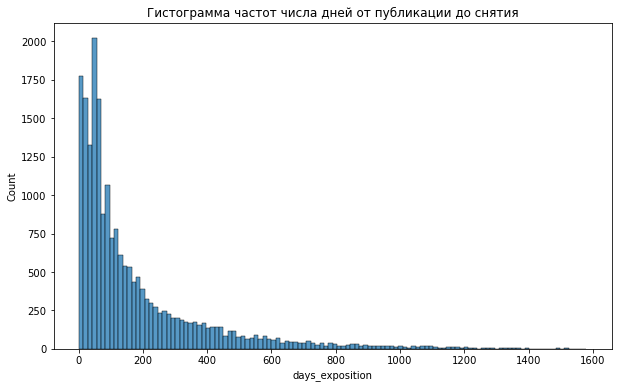

In [150]:
plt.figure(figsize=(10, 6))
sns.histplot(
    real_estate_df,
    x='days_exposition'
)
plt.title('Гистограмма частот числа дней от публикации до снятия');

Как видно, обычно продажа квартиры занимает от 45 до 232 дней. Посчитаем медиану и среднее время продажи квартиры.

In [151]:
print('Медиана числа дней от публикации до снятия', real_estate_df['days_exposition'].median())
print('Среднее числа дней от публикации до снятия', real_estate_df['days_exposition'].mean())

Медиана числа дней от публикации до снятия 95.0
Среднее числа дней от публикации до снятия 180.9095607235142


При такой ассиметрии не удивительно, что медиана оказалась почти в два раза меньше среднего значения. А между тем, медиана показывает, что 50% квартир было продано за 95 дней или меньше.  
Теперь разделим объявления на те, что очень быстро были закрыты, и те, что слишком долго находились на сайте. Предположим, что нижней границей является 30 дней = 1 месяц, а верхней - 540 дней = 1.5 года, и создадим новый датафрейм со столбцами "населённый пункт", "время продажи", "продана очень быстро" и "продана очень медленно".

In [152]:
days_exp_df = pd.DataFrame(real_estate_df[['locality_name', 'days_exposition']], columns=['locality_name', 'days_exposition'])
days_exp_df['sold_too_fast'] = days_exp_df['days_exposition'] < 30
days_exp_df['sold_too_slow'] = days_exp_df['days_exposition'] > 540
days_exp_df.head()

,locality_name,days_exposition,sold_too_fast,sold_too_slow
0,Санкт-Петербург,NaN,False,False
1,поселок Шушары,81.0,False,False
2,Санкт-Петербург,558.0,False,True
3,Санкт-Петербург,424.0,False,False
4,Санкт-Петербург,121.0,False,False


А теперь сгруппируем объявления по городам, посчитаем средние значения по оставшимся столбцам и построим матрицу рассеяния.

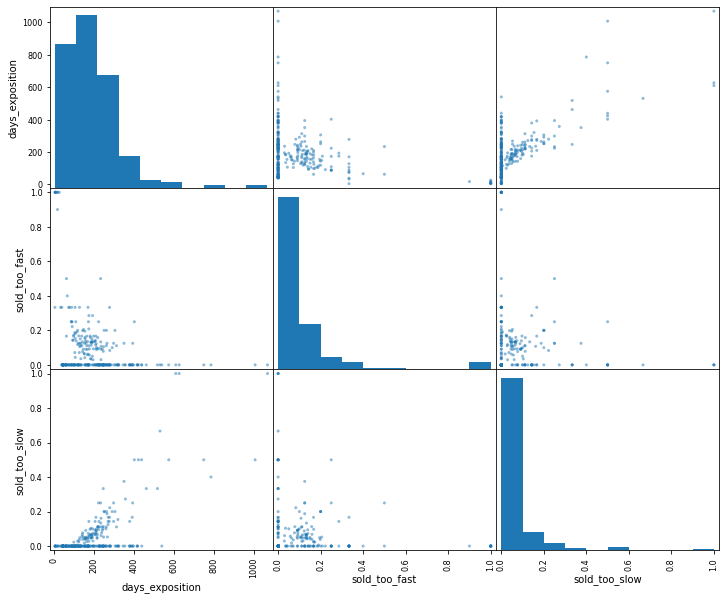

In [153]:
days_exp_pivot = days_exp_df.pivot_table(index='locality_name', values=['days_exposition', 'sold_too_fast', 'sold_too_slow'])
pd.plotting.scatter_matrix(days_exp_pivot, figsize=(12, 10));

Видно, что графики в целом не противоречат логике: чем больше доля быстро проданных квартир, тем меньше среднее время продажи, и чем больше доля долгих продаж, тем больше и среднее время продажи квартиры - значит, границы выбраны правильно. Отметим наличие таких населённых пунктов, в которых независимо от среднего времени продажи отсутствуют быстро проданные квартиры либо проданные за очень долгий срок.  
Теперь отфильтруем записи с быстрой и долгой продажей.

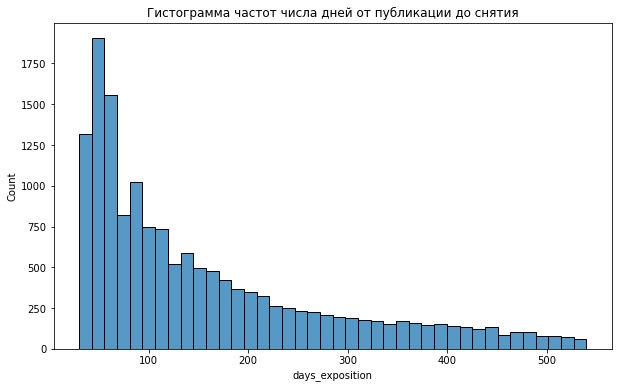

In [154]:
real_estate_filtred_df = real_estate_df.query('days_exposition >= 30 and days_exposition <= 540')

plt.figure(figsize=(10, 6))
sns.histplot(
    real_estate_filtred_df,
    x='days_exposition'
)
plt.title('Гистограмма частот числа дней от публикации до снятия');

Посмотрим, зависит ли цена от общей площади квартиры, числа комнат, расстояния до центра, класса этажа, дня недели, месяца и года размещения объявления.

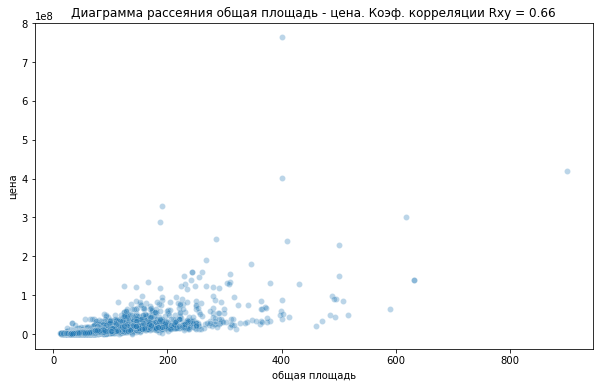

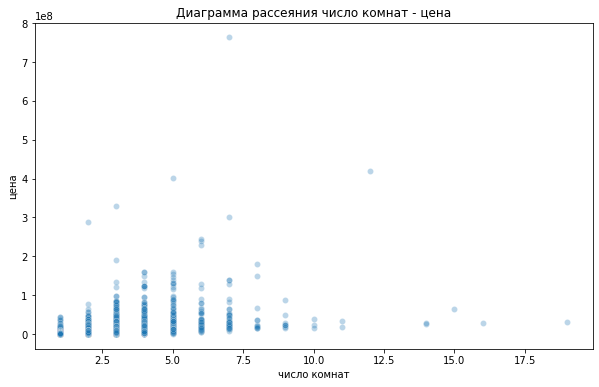

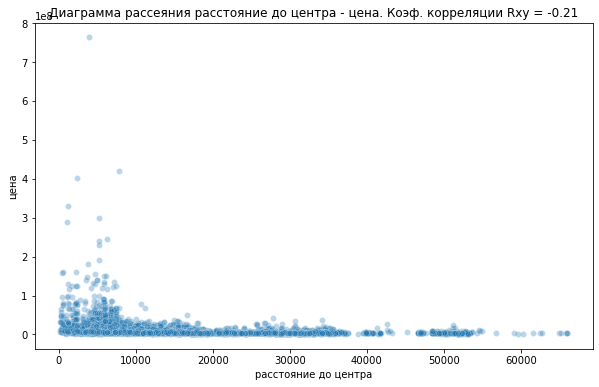

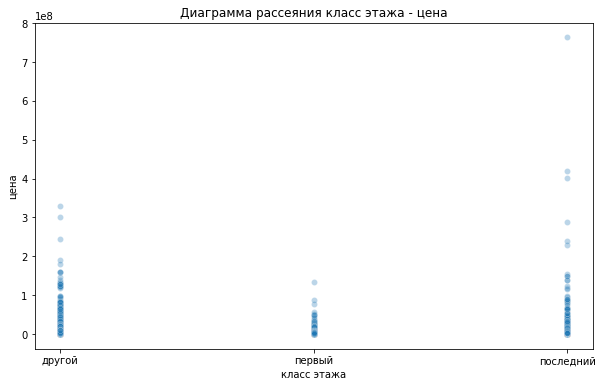

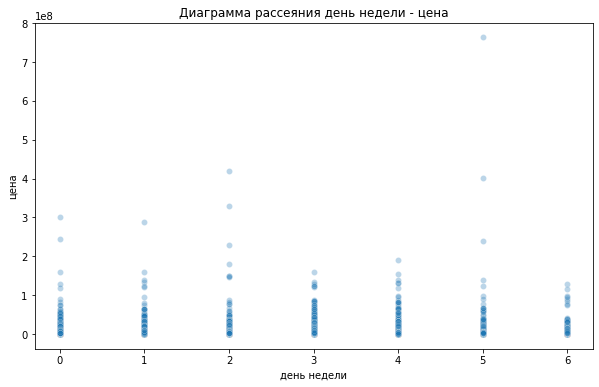

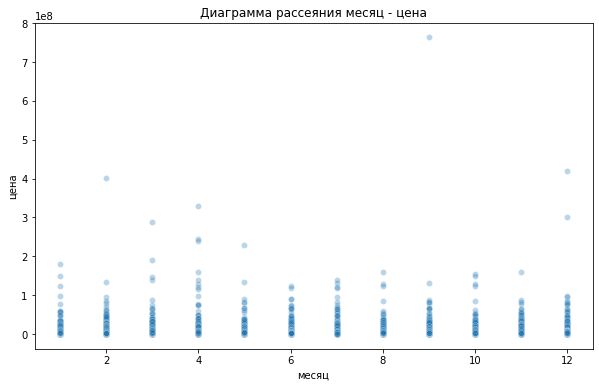

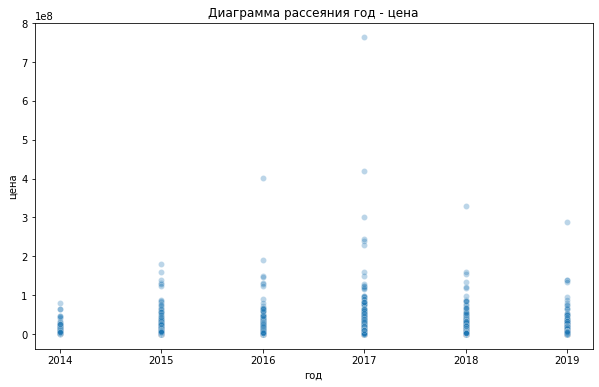

In [160]:
cols = ['last_price', 'total_area', 'rooms', 'city_centers_nearest', 'floor_class', 'weekday_exposition',
        'month_exposition', 'year_exposition']
cols_rus = ['цена', 'общая площадь', 'число комнат', 'расстояние до центра', 'класс этажа', 'день недели', 'месяц', 'год']

for i, col in enumerate(cols[1:]):
    
    ttl = 'Диаграмма рассеяния ' + cols_rus[i + 1] + ' - ' + cols_rus[0]
    
    if real_estate_df[col].dtype in ['float', 'int']:
        corr_coef = real_estate_df[cols[0]].corr(real_estate_df[col])
        ttl += '. Коэф. корреляции Rxy = ' + str(round(corr_coef, ndigits=2))
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=col,
        y=cols[0],
        data=real_estate_df,
        alpha=0.3
    )
    
    plt.xlabel(cols_rus[i + 1])
    plt.ylabel(cols_rus[0])
    plt.title(ttl);

Средняя корреляция прослеживается только у цены от площади квартиры, что не противоречит реальности. Слабая корреляция заметна между ценой и числом комнат, но это лишь отчасти правда, так как обычно в квартирах с большой площадью планировка предполагает 5 и больше комнат, но нередко бывает, что в квартире с большей площадью может быть столько же или меньше комнат, чем во в квартире с меньшей площадью. Также слабо коррелирует цена с расстоянием до центра города, причём зависимость похожа на обратную, однако скорее разброс цены и её среднее увеличиваются при приближении к центру города. Таким образом, площадь квартиры является тем фактором, который больше всего влияет на цену (из выбранных факторов).  
Выберем 10 населённых пунктов с наибольшим числом объявлений.

In [161]:
top_10_cities_by_ad_count = real_estate_df['locality_name'].value_counts().head(10)
top_10_cities_by_ad_count

Санкт-Петербург      15757
поселок Мурино         556
поселок Шушары         440
Всеволожск             398
Пушкин                 371
Колпино                338
поселок Парголово      327
Гатчина                307
деревня Кудрово        299
Выборг                 237
Name: locality_name, dtype: int64

Посчитаем среднюю цену квадратного метра в этих населённых пунктах и выделим среди них населённые пункты с самой высокой и низкой стоимостью жилья.

In [163]:
top_10_cities_by_ad_count_rub_per_sqm = (
    real_estate_df
    .query('locality_name in @top_10_cities_by_ad_count.index',
           local_dict={'top_10_cities_by_ad_count': top_10_cities_by_ad_count})
    .pivot_table(index='locality_name', values='cost_per_square_meter')
    .sort_values(by='cost_per_square_meter', ascending=False)
)

print('Населённый пункт с самой высокой ценой квадратного метра:', top_10_cities_by_ad_count_rub_per_sqm.index.values[0])
print('Населённый пункт с самой низкой ценой квадратного метра:', top_10_cities_by_ad_count_rub_per_sqm.index.values[-1])
top_10_cities_by_ad_count_rub_per_sqm

Населённый пункт с самой высокой ценой квадратного метра: Санкт-Петербург
Населённый пункт с самой низкой ценой квадратного метра: Выборг


,cost_per_square_meter
locality_name,
Санкт-Петербург,114831.183309
Пушкин,102915.060863
деревня Кудрово,92473.547559
поселок Парголово,90175.913089
поселок Мурино,85681.762572
поселок Шушары,78677.364318
Колпино,75424.579112
Гатчина,68746.146515
Всеволожск,68654.473970


Изучим предложения квартир в Санкт-Петербурге, чтобы выяснить, какая область входит в центр. Для этого создадим столбец с расстоянием до центра в километрах, после этого посчитаем среднюю цену для каждого километра и построим график зависимости цены от расстояния до центра.

In [164]:
real_estate_df['city_centers_nearest_km'] = round(real_estate_df['city_centers_nearest'] / 1000)
real_estate_df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,is_sold,corresponds_to_building regulations,floors_total,living_area,...,ponds_nearest,days_exposition,cost_per_square_meter,weekday_exposition,month_exposition,year_exposition,floor_class,living_total_area_proportion,kitchen_total_area_proportion,city_centers_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,0,1,16,51.0,...,755.0,NaN,120370.37,3,3,2019,другой,0.472222,0.231481,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.60,1,1,11,18.6,...,NaN,81.0,82920.79,1,12,2018,первый,0.460396,0.272277,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.50,1,1,5,34.3,...,574.0,558.0,92785.71,3,8,2015,другой,0.612500,0.148214,14.0
3,0,64900000.0,159.0,2015-07-24,3,3.00,1,1,14,88.0,...,234.0,424.0,408176.10,4,7,2015,другой,0.553459,0.138365,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,1,1,14,32.0,...,48.0,121.0,100000.00,1,6,2018,другой,0.320000,0.410000,8.0


Text(0.5, 1.0, 'График зависимости средней цены от расстояния до центра Санкт-Петербурга')

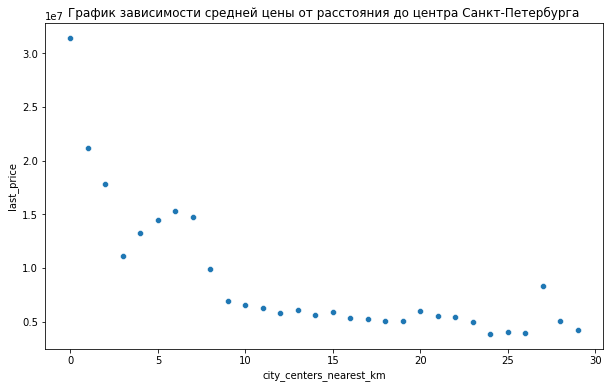

In [166]:
price_per_km_in_spb = (
    real_estate_df
    .query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='city_centers_nearest_km', values='last_price')
)
price_per_km_in_spb.reset_index(inplace=True)
price_per_km_in_spb.columns = ['city_centers_nearest_km', 'last_price']

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='city_centers_nearest_km',
    y='last_price',
    data=price_per_km_in_spb
)
plt.title('График зависимости средней цены от расстояния до центра Санкт-Петербурга')

На графике заметны два начала стремительного роста средней цены: в районе 3 и 9 км. Ввиду более сильного скачка цены при переходе от 3 к 2 км будем считать 3 км границей центральной зоны.  
Выделим сегмент квартир в центре и проанализируем факторы, которые могут влиять на цену квартиры: площадь, число комнат, высота потолков, этаж, удалённость от центра, дата размещения объявления.

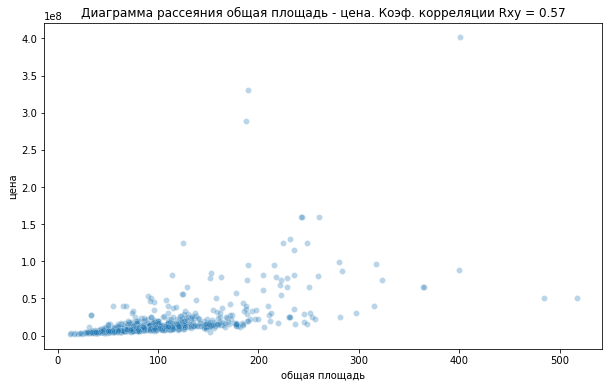

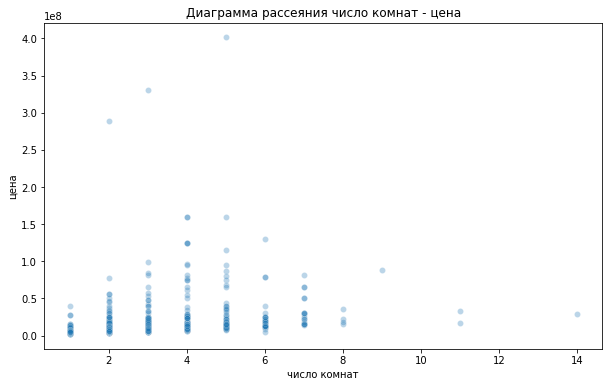

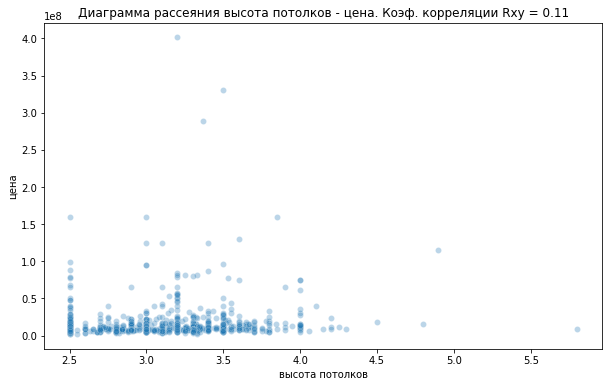

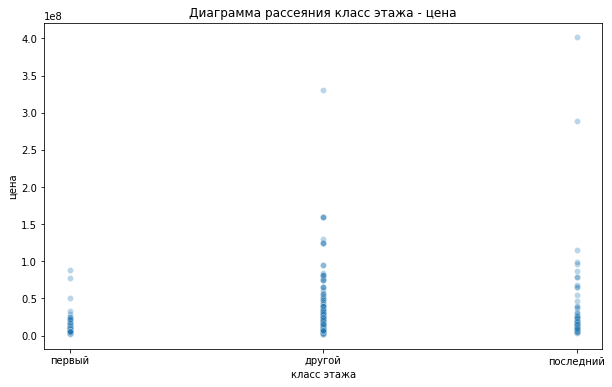

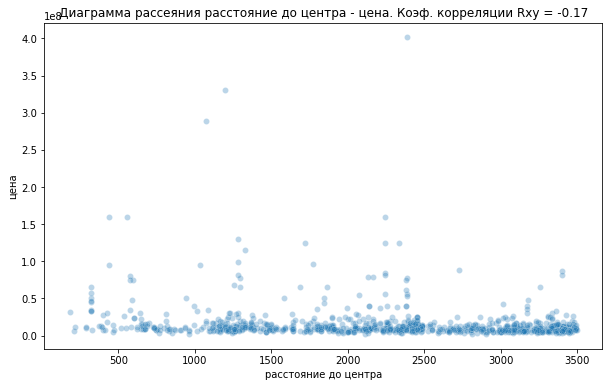

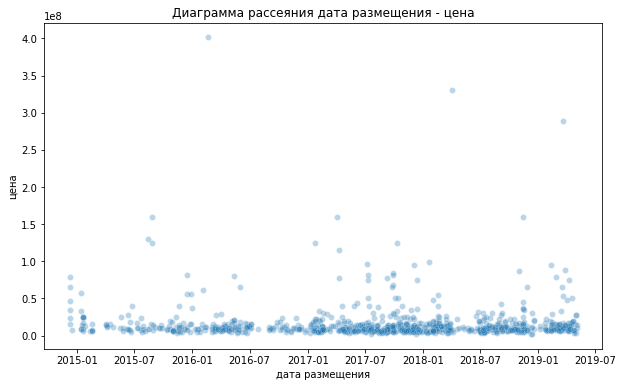

In [173]:
cols = ['last_price', 'total_area', 'rooms', 'ceiling_height', 'floor_class', 'city_centers_nearest',
        'first_day_exposition']
cols_rus = ['цена', 'общая площадь', 'число комнат', 'высота потолков', 'класс этажа',
            'расстояние до центра', 'дата размещения']

spb_center_ads_df = real_estate_df.query('locality_name == "Санкт-Петербург" and city_centers_nearest_km <= 3')

for i, col in enumerate(cols[1:]):
    
    ttl = 'Диаграмма рассеяния ' + cols_rus[i + 1] + ' - ' + cols_rus[0]
    
    if spb_center_ads_df[col].dtype in ['float', 'int']:
        corr_coef = spb_center_ads_df[cols[0]].corr(spb_center_ads_df[col])
        ttl += '. Коэф. корреляции Rxy = ' + str(round(corr_coef, ndigits=2))
            
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=spb_center_ads_df,
        x=col,
        y=cols[0],
        alpha=0.3
    )
    
    plt.xlabel(cols_rus[i + 1])
    plt.ylabel(cols_rus[0])
    plt.title(ttl)

Выводы здесь примерно такие же, как и в случае всех объявлений: самый влияющий фактор - площадь квартиры, остальные коррелируют слабо и очень слабо.

### Вывод

* Изучены площадь, цена, число комнат, высота потолков, для каждого параметра построены гистограммы.
* Изучено время продажи квартиры. Обычно продажа занимает 6 месяцев. Можно считать, что продажи прошли очень быстро, если от размещения до снятия прошло меньше месяца, а если больше 1,5 лет, то очень долго.
* Из всех рассмотренных факторов (площадь, число комнат, удалённость от центра, этаж, день недели, месяц и год размещения объявления) больше всего влияет на стоимость площадь квартиры.
* Среди 10 населённых пунктов с наибольшим числом объявлений посчитана средняя цена квадратного метра. Выделены населённые пункты с самой высокой (Санкт-Петербург) и низкой стоимостью жилья (Выборг).
* Найдена центральная зона в Санкт-Петербурге: в радиусе 3 км от центра города.
* Выделен сегмент квартир в центре и проанализированы факторы, которые могут влиять на цену квартиры: площадь, число комнат, высота потолков, этаж, удалённость от центра, дата размещения объявления. Выводы здесь примерно такие же, как и в случае всех объявлений: самый влияющий фактор - площадь квартиры, остальные коррелируют слабо и с таким же характером, как и в случае всех объявлений.

### Шаг 5. Общий вывод

В ходе работы были выполнены следующие задачи:
1. Изучены входные данные. В ходе первичного анализа были обнаружены пропуски, аномальные значения, а также неявные дубликаты.
2. Переименованы столбцы в соответствии с содержимым и принятым стилем.
3. Обработаны пропуски путём заполнения выбранными в зависимости от условий значениями.
4. Выполнено приведение типов.
5. Обработаны аномалии.
6. Дубликатов найдено не было.
7. Добавлены столбцы "соответствует СНиП" по высоте потолка и "продано".
8. Рассчитаны и добавлены столбцы "цена квадратного метра", "день недели", "месяц" и "год" публикации объявления, "этаж квартиры", "соотношение жилой и общей площади", а также "отношение площади кухни к общей".
9. Проведён исследовательский анализ данных:
    * Изучены площадь, цена, число комнат, высота потолков, для каждого параметра построены гистограммы.
    * Изучено время продажи квартиры. Обычно продажа занимает 6 месяцев. Можно считать, что продажи прошли очень быстро, если от размещения до снятия прошло меньше месяца, а если больше 1,5 лет, то очень долго.
    * Из всех рассмотренных факторов (площадь, число комнат, удалённость от центра, этаж, день недели, месяц и год размещения объявления) больше всего влияет на стоимость площадь квартиры.
    * Среди 10 населённых пунктов с наибольшим числом объявлений посчитана средняя цена квадратного метра. Выделены населённые пункты с самой высокой (Санкт-Петербург) и низкой стоимостью жилья (Выборг).
    * Найдена центральная зона в Санкт-Петербурге: в радиусе 3 км от центра города.
    * Выделен сегмент квартир в центре и проанализированы факторы, которые могут влиять на цену квартиры: площадь, число комнат, высота потолков, этаж, удалённость от центра, дата размещения объявления. Выводы здесь примерно такие же, как и в случае всех объявлений: самый влияющий фактор - площадь квартиры, остальные коррелируют слабо и с таким же характером, как и в случае всех объявлений.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод